# Advanced Topic Modeling with Transformer-Based Embeddings

This notebook implements an integrated framework that combines modern transformer-based embeddings with clustering techniques to discover latent topics in text corpora without manual labeling or supervision. We'll be working with the BBC News Dataset.

## Project Components:
1. Understanding the BBC News Dataset
2. Implementing a pipeline using RoBERTa embeddings for document representation
3. Applying dimensionality reduction techniques (PCA, t-SNE, UMAP)
4. Implementing and comparing clustering algorithms (K-means, hierarchical clustering)
5. Developing methods to extract and label discovered topics
6. Creating visualizations for topic space exploration

## Setup and Dependencies

Let's first import the necessary libraries and set up our environment.

In [ ]:
# Install required packages if not already installed
# !pip install transformers scikit-learn numpy pandas matplotlib seaborn umap-learn nltk plotly wordcloud tensorflow sentencepiece hdbscan

# Install required packages with specific versions 
# Because I had some issues afterwards in the web application for some models after exportation
!pip install transformers==4.36.2
!pip install scikit-learn==1.3.2
!pip install numpy==1.26.2
!pip install pandas==2.1.3
!pip install matplotlib==3.8.2
!pip install seaborn==0.13.0
!pip install umap-learn==0.5.4  
!pip install nltk==3.8.1
!pip install plotly==5.18.0
!pip install wordcloud==1.9.2
!pip install numba==0.58.1       

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, adjusted_rand_score, homogeneity_score, v_measure_score
from sklearn.preprocessing import normalize, LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Model Choice after running the becnhmarking notebook
from transformers import RobertaTokenizer, RobertaModel

import torch
import umap
import re
import time
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud
from collections import Counter
import requests
import os
from zipfile import ZipFile
from io import BytesIO
import hdbscan

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Configure matplotlib
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.11/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading pac

# 1. Understanding the BBC News Dataset

The BBC News dataset consists of 2,225 documents from the BBC news website corresponding to articles in five topical areas from 2004-2005. The dataset is organized into 5 categories: business, entertainment, politics, sport, and tech.

Let's download and load the dataset.

In [3]:
# Function to download and extract the dataset
def download_bbc_dataset():
    dataset_url = "http://mlg.ucd.ie/files/datasets/bbc-fulltext.zip"
    print("Downloading BBC News dataset...")

    response = requests.get(dataset_url)
    zip_file = ZipFile(BytesIO(response.content))

    # Create directory if it doesn't exist
    if not os.path.exists('bbc'):
        os.makedirs('bbc')

    print("Extracting dataset...")
    zip_file.extractall('.')
    print("Dataset downloaded and extracted successfully!")

# Download the dataset if it doesn't exist
if not os.path.exists('bbc'):
    download_bbc_dataset()

Extracting dataset...
Dataset downloaded and extracted successfully!


In [4]:
# Load the dataset
def load_bbc_dataset(directory="bbc"):
    categories = os.listdir(directory)
    # Filter out any non-directory items
    categories = [cat for cat in categories if os.path.isdir(os.path.join(directory, cat))]

    texts = []
    labels = []
    file_paths = []

    print(f"Loading documents from categories: {categories}")

    for category in categories:
        category_path = os.path.join(directory, category)
        files = os.listdir(category_path)

        for file in files:
            file_path = os.path.join(category_path, file)
            try:
                with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                    text = f.read()
                    texts.append(text)
                    labels.append(category)
                    file_paths.append(file_path)
            except Exception as e:
                print(f"Error reading file {file_path}: {e}")

    # Create a DataFrame
    df = pd.DataFrame({
        'text': texts,
        'category': labels,
        'file_path': file_paths
    })

    return df

# Load the dataset
df = load_bbc_dataset()

# Display basic information
print(f"Dataset shape: {df.shape}")
print(f"Number of samples: {len(df)}")
print(f"Number of categories: {df['category'].nunique()}")
print(f"Categories: {df['category'].unique()}")

Loading documents from categories: ['business', 'sport', 'entertainment', 'tech', 'politics']
Dataset shape: (2225, 3)
Number of samples: 2225
Number of categories: 5
Categories: ['business' 'sport' 'entertainment' 'tech' 'politics']


In [ ]:
df.head()

text  category  \
0  Circuit City gets takeover offer\n\nCircuit Ci...  business   
1  Dollar hovers around record lows\n\nThe US dol...  business   
2  Euronext joins bid battle for LSE\n\nPan-Europ...  business   
3  Police detain Chinese milk bosses\n\nChinese p...  business   
4  Golden rule 'intact' says ex-aide\n\nChancello...  business   

              file_path  
0  bbc/business/070.txt  
1  bbc/business/374.txt  
2  bbc/business/319.txt  
3  bbc/business/338.txt  
4  bbc/business/106.txt

In [6]:
# Check class distribution
category_counts = df['category'].value_counts()
print("Category distribution:")
for category, count in category_counts.items():
    print(f"{category}: {count} documents ({count/len(df)*100:.2f}%)")

Category distribution:
sport: 511 documents (22.97%)
business: 510 documents (22.92%)
politics: 417 documents (18.74%)
tech: 401 documents (18.02%)
entertainment: 386 documents (17.35%)


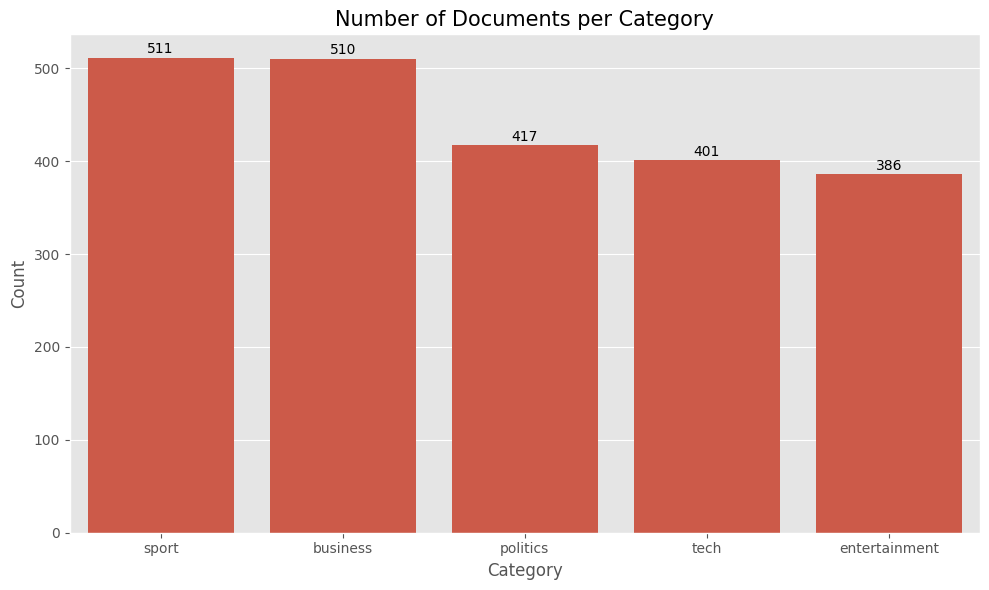

In [7]:
# Visualize category distribution
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=category_counts.index, y=category_counts.values)
plt.title('Number of Documents per Category', fontsize=15)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.xticks(rotation=0)

# Add count labels on top of each bar
for i, count in enumerate(category_counts.values):
    ax.text(i, count + 5, str(count), ha='center')

plt.tight_layout()
plt.show()

In [8]:
# Analyze document length distribution
df['doc_length'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

# Summary statistics for document length
print("Document length statistics (characters):")
print(df['doc_length'].describe())

print("\nWord count statistics:")
print(df['word_count'].describe())

Document length statistics (characters):
count     2225.000000
mean      2265.160449
std       1364.094764
min        503.000000
25%       1448.000000
50%       1967.000000
75%       2804.000000
max      25485.000000
Name: doc_length, dtype: float64

Word count statistics:
count    2225.000000
mean      384.040449
std       238.174497
min        89.000000
25%       246.000000
50%       332.000000
75%       471.000000
max      4432.000000
Name: word_count, dtype: float64


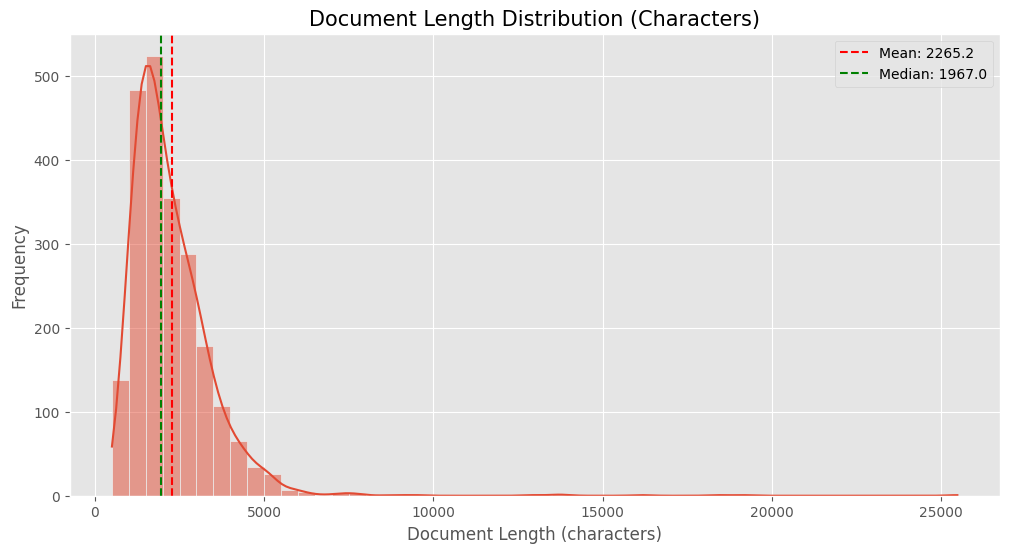

In [9]:
# Visualize document length distribution
plt.figure(figsize=(12, 6))
sns.histplot(df['doc_length'], bins=50, kde=True)
plt.title('Document Length Distribution (Characters)', fontsize=15)
plt.xlabel('Document Length (characters)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(df['doc_length'].mean(), color='red', linestyle='--', label=f'Mean: {df["doc_length"].mean():.1f}')
plt.axvline(df['doc_length'].median(), color='green', linestyle='--', label=f'Median: {df["doc_length"].median():.1f}')
plt.legend()
plt.show()

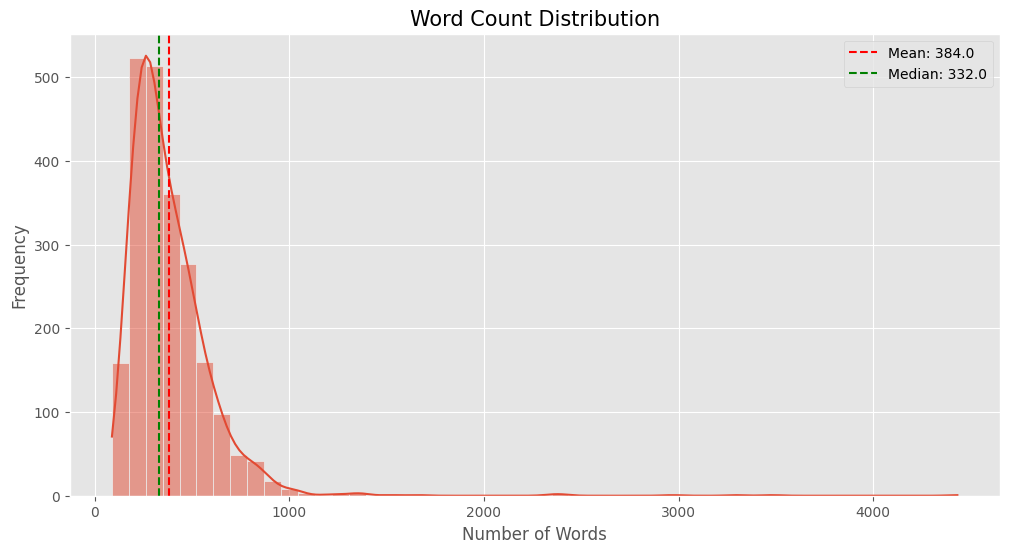

In [10]:
# Visualize word count distribution
plt.figure(figsize=(12, 6))
sns.histplot(df['word_count'], bins=50, kde=True)
plt.title('Word Count Distribution', fontsize=15)
plt.xlabel('Number of Words', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(df['word_count'].mean(), color='red', linestyle='--', label=f'Mean: {df["word_count"].mean():.1f}')
plt.axvline(df['word_count'].median(), color='green', linestyle='--', label=f'Median: {df["word_count"].median():.1f}')
plt.legend()
plt.show()

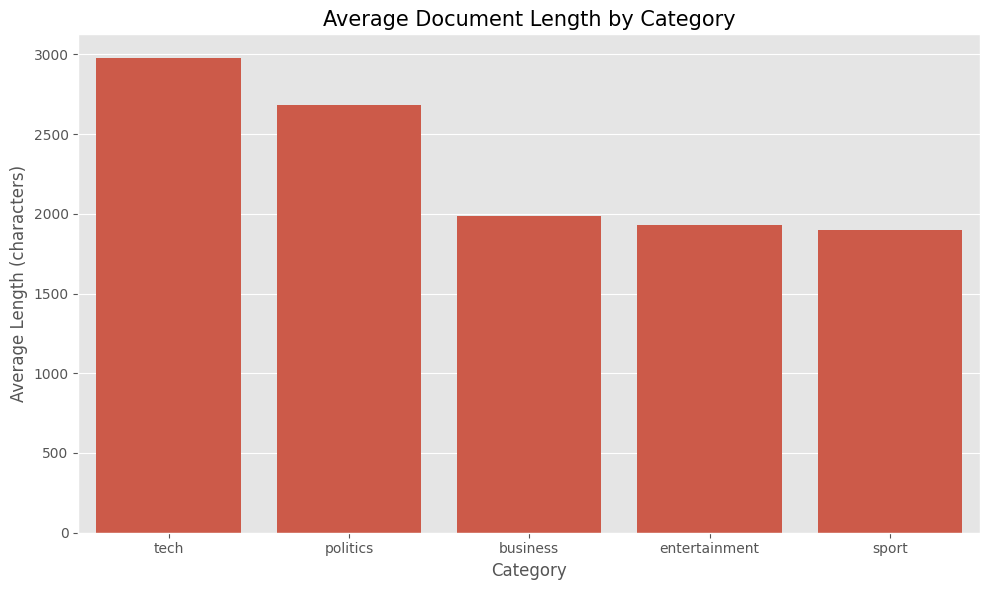

In [11]:
# Calculate average document length by category
avg_length_by_category = df.groupby('category')['doc_length'].mean().sort_values(ascending=False)

# Visualize average document length by category
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_length_by_category.index, y=avg_length_by_category.values)
plt.title('Average Document Length by Category', fontsize=15)
plt.ylabel('Average Length (characters)', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

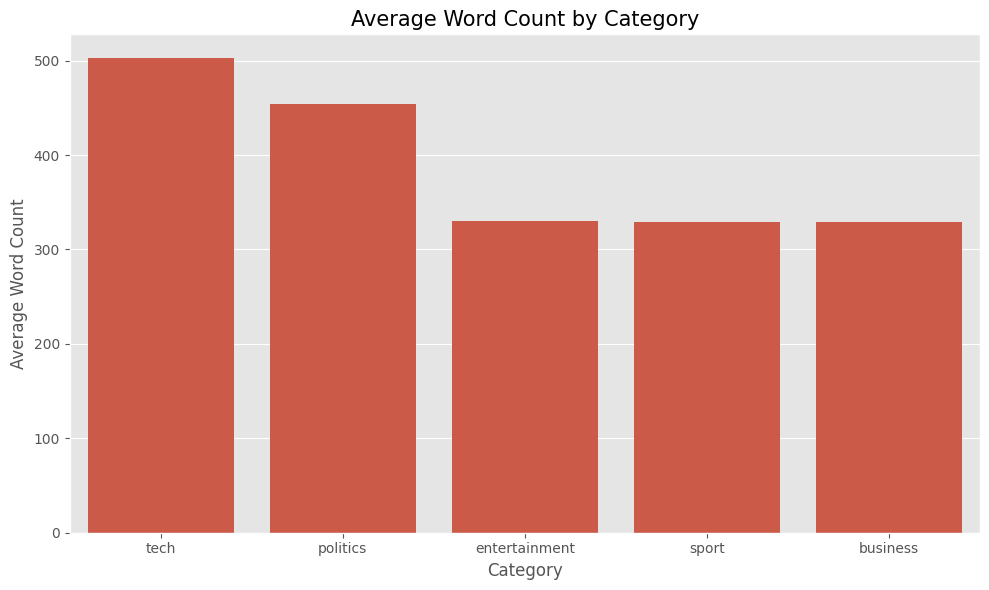

In [12]:
# Calculate average word count by category
avg_words_by_category = df.groupby('category')['word_count'].mean().sort_values(ascending=False)

# Visualize average word count by category
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_words_by_category.index, y=avg_words_by_category.values)
plt.title('Average Word Count by Category', fontsize=15)
plt.ylabel('Average Word Count', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [13]:
# Define function to extract top words
def get_top_words(texts, n=20):
    stop_words = set(stopwords.words('english'))
    all_words = []

    for text in texts:
        # Tokenize, convert to lowercase, and remove stopwords, numbers, and short words
        words = [word.lower() for word in word_tokenize(text)
                if word.isalpha() and word.lower() not in stop_words and len(word) > 3]
        all_words.extend(words)

    # Count word frequencies
    word_freq = Counter(all_words)
    return word_freq.most_common(n)

# Get top words in the entire dataset
top_words_all = get_top_words(df['text'])

# Display top words
print("Top 20 words across all categories:")
for word, count in top_words_all:
    print(f"{word}: {count}")

Top 20 words across all categories:
said: 7253
would: 2629
also: 2156
people: 2044
year: 1825
could: 1546
last: 1380
first: 1282
world: 1183
government: 1153
time: 1147
years: 1002
make: 926
best: 921
told: 911
game: 857
made: 856
film: 853
like: 838
music: 832


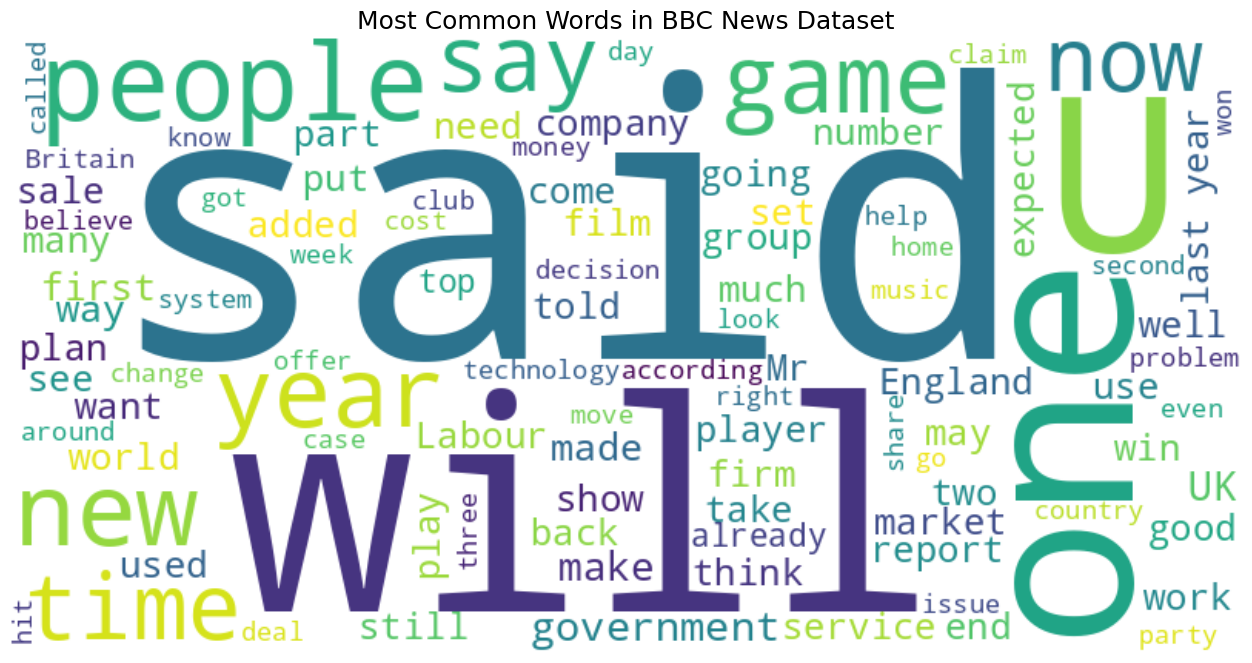

In [14]:
# Create wordcloud for the entire dataset
wordcloud = WordCloud(width=800, height=400, background_color='white',
                     max_words=100, contour_width=3, contour_color='steelblue')
wordcloud.generate(' '.join([text for text in df['text']]))

plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in BBC News Dataset', fontsize=18)
plt.show()

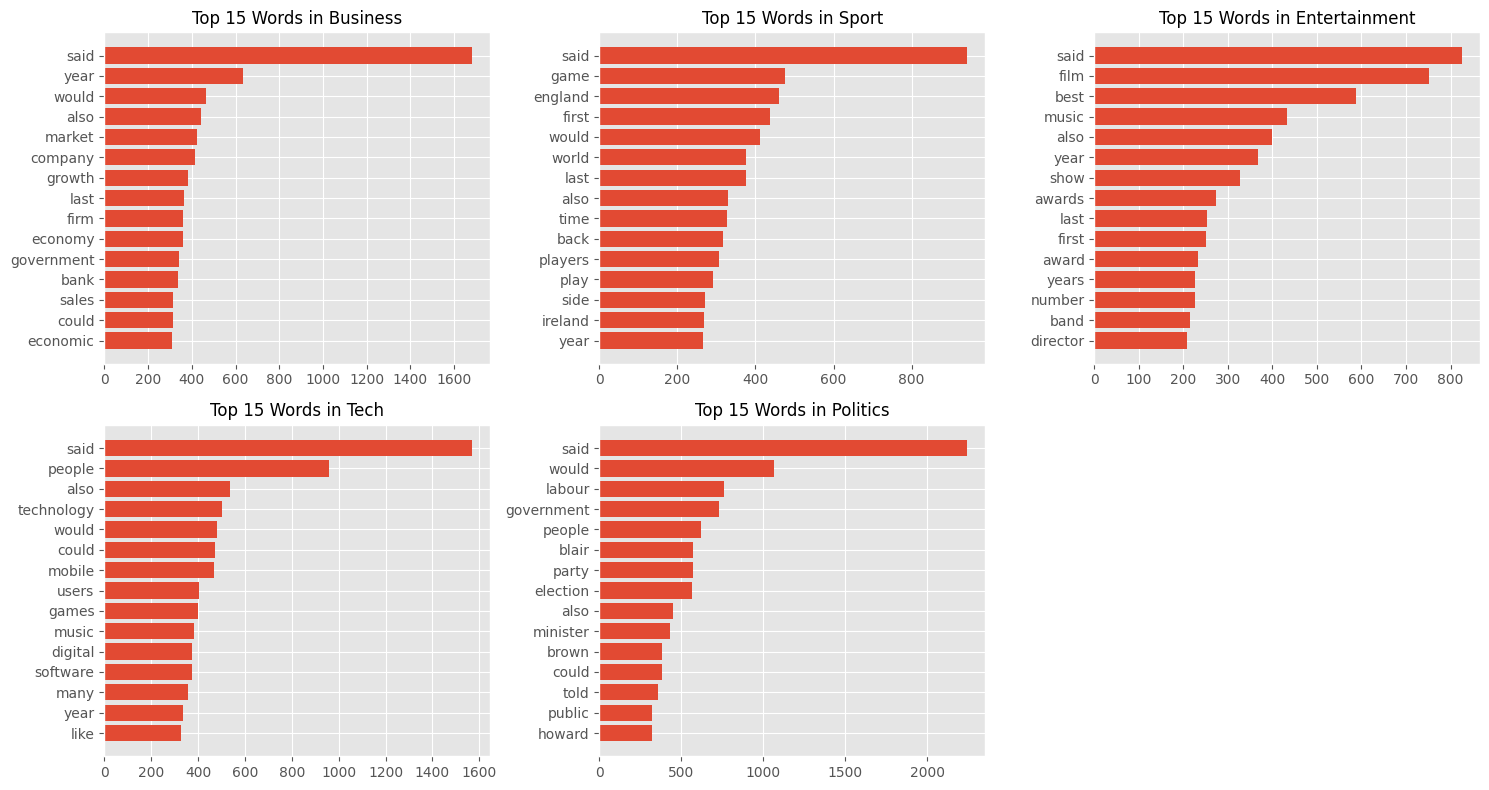

In [15]:
# Analyze top words by category
def plot_top_words_by_category(df, n_words=10, n_cols=3):
    categories = df['category'].unique()
    n_rows = (len(categories) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
    axes = axes.flatten()

    for i, category in enumerate(categories):
        if i < len(axes):
            category_texts = df[df['category'] == category]['text']
            top_words = get_top_words(category_texts, n=n_words)

            words, counts = zip(*top_words)
            axes[i].barh(range(len(words)), counts, align='center')
            axes[i].set_yticks(range(len(words)))
            axes[i].set_yticklabels(words)
            axes[i].invert_yaxis()  # Highest values at the top
            axes[i].set_title(f'Top {n_words} Words in {category.capitalize()}', fontsize=12)

    # Hide unused subplots
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Plot top words by category
plot_top_words_by_category(df, n_words=15, n_cols=3)

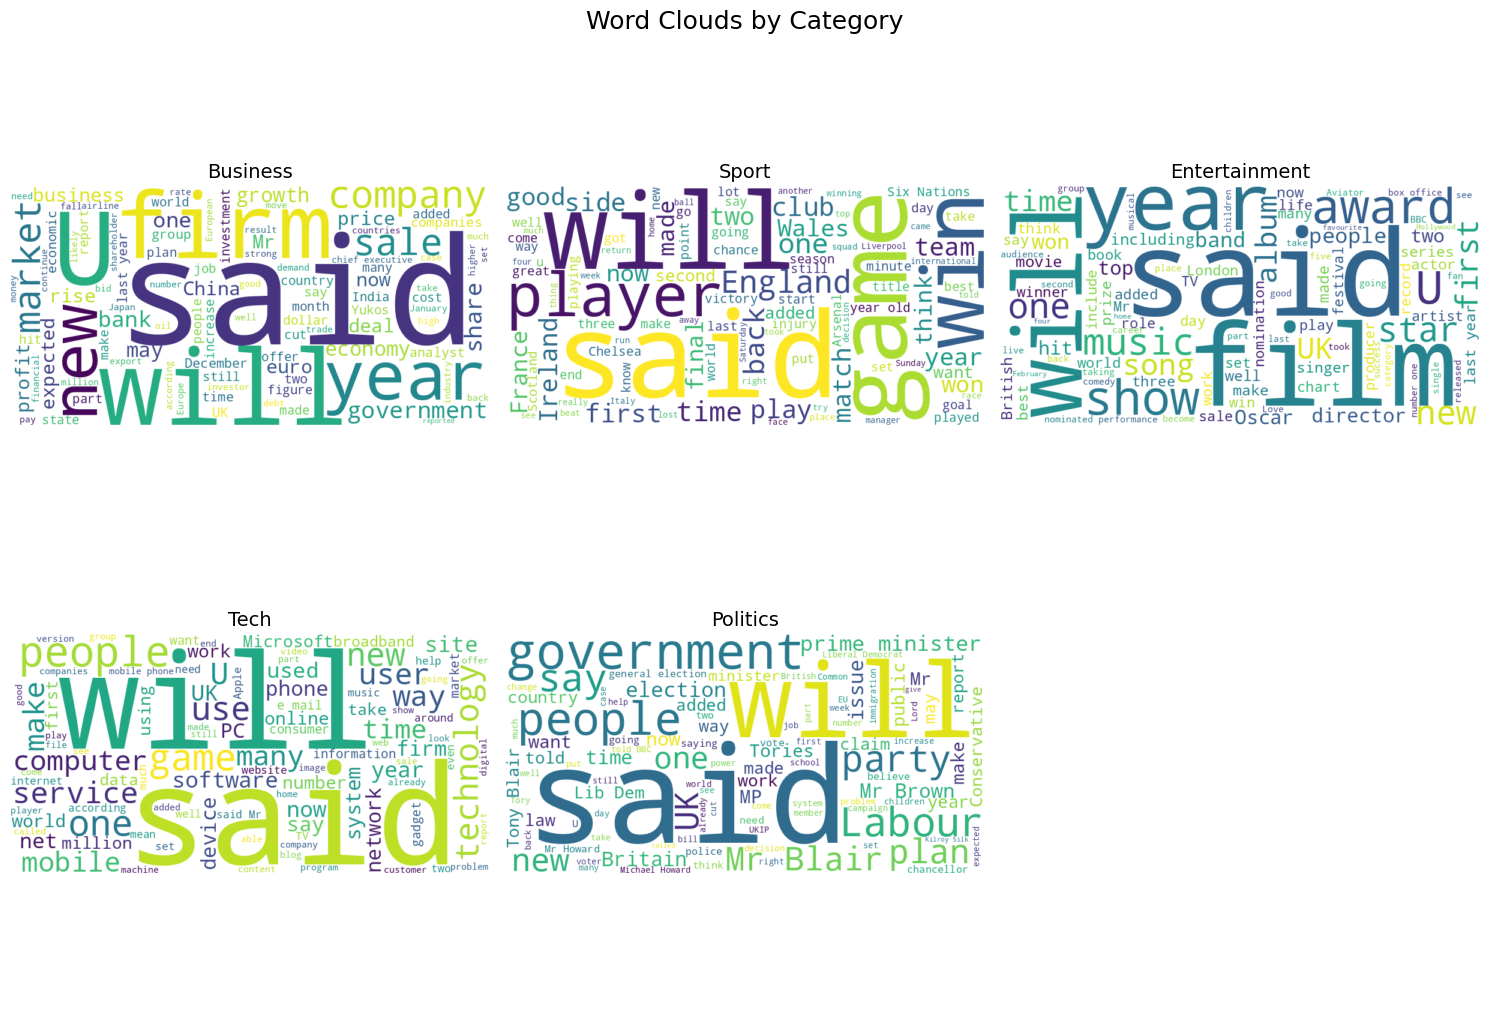

In [16]:
# Create wordclouds for each category
def generate_category_wordclouds(df):
    categories = df['category'].unique()
    n_cols = 3
    n_rows = (len(categories) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = axes.flatten()

    for i, category in enumerate(categories):
        if i < len(axes):
            # Get texts for this category
            category_texts = df[df['category'] == category]['text']

            # Create and generate wordcloud
            wc = WordCloud(width=800, height=400, background_color='white',
                         max_words=100, contour_width=3, contour_color='steelblue')
            wc.generate(' '.join(category_texts))

            # Display wordcloud
            axes[i].imshow(wc, interpolation='bilinear')
            axes[i].axis('off')
            axes[i].set_title(f'{category.capitalize()}', fontsize=14)

    # Hide unused subplots
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.suptitle('Word Clouds by Category', fontsize=18, y=1.02)
    plt.show()

# Generate category wordclouds
generate_category_wordclouds(df)

In [17]:
# Analyze document similarity within and between categories
# This helps us understand how distinctive the categories are

# Create TF-IDF vectors for similarity analysis
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df['text'])

# Convert to a matrix format
tfidf_dense = tfidf_matrix.toarray()

# Compute document similarity matrix
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(tfidf_dense)

print(tfidf_matrix.shape)
print(similarity_matrix.shape)

(2225, 5000)
(2225, 2225)


In [18]:
# Calculate average similarity within each category
categories = df['category'].unique()
within_similarity = {}
between_similarity = {}

for category in categories:
    # Get indices of documents in this category
    indices = df[df['category'] == category].index.tolist()

    # Get similarity values for this category
    category_similarity = []
    for i in range(len(indices)):
        for j in range(i+1, len(indices)):
            category_similarity.append(similarity_matrix[indices[i], indices[j]])

    if category_similarity:
        within_similarity[category] = np.mean(category_similarity)

    # Calculate between-category similarity
    other_indices = [i for i in range(len(df)) if i not in indices]
    between_category_similarity = []

    for i in indices:
        for j in other_indices:
            between_category_similarity.append(similarity_matrix[i, j])

    if between_category_similarity:
        between_similarity[category] = np.mean(between_category_similarity)

# Display results
print("Average document similarity within each category:")
for category, sim in within_similarity.items():
    print(f"{category}: {sim:.4f}")

print("\nAverage document similarity between each category and all others:")
for category, sim in between_similarity.items():
    print(f"{category}: {sim:.4f}")

Average document similarity within each category:
business: 0.0505
sport: 0.0521
entertainment: 0.0561
tech: 0.0603
politics: 0.0780

Average document similarity between each category and all others:
business: 0.0222
sport: 0.0186
entertainment: 0.0211
tech: 0.0232
politics: 0.0247


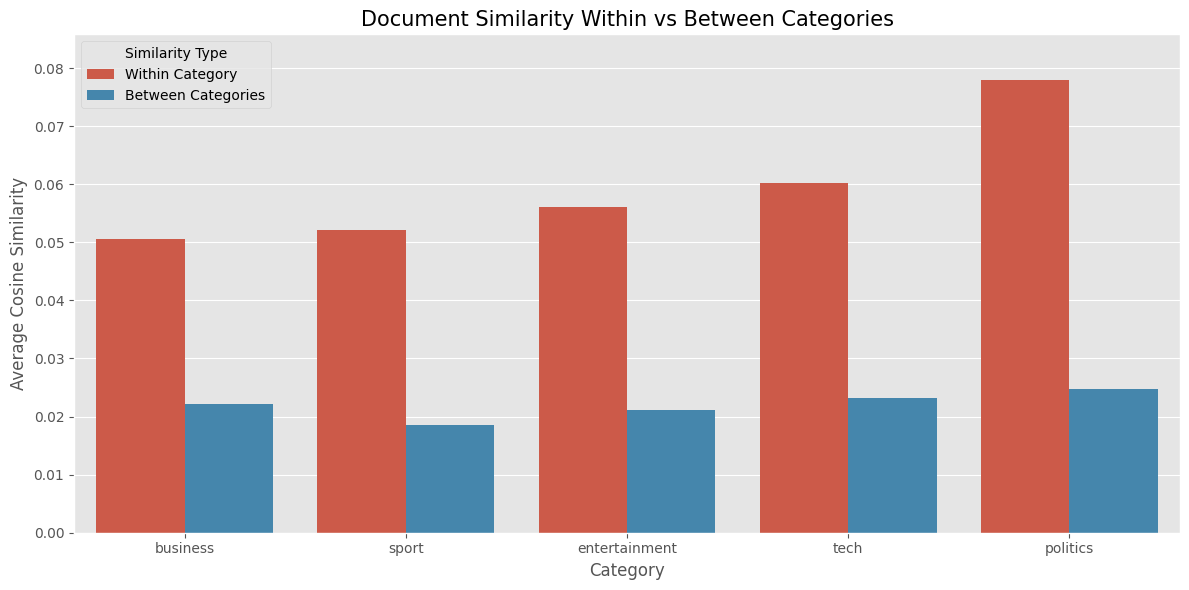

In [ ]:
# Visualize similarity metrics
comparison_df = pd.DataFrame({
    'Category': list(within_similarity.keys()),
    'Within Category': list(within_similarity.values()),
    'Between Categories': list(between_similarity.values())
})

# Melt the dataframe for easier plotting
melted_df = pd.melt(comparison_df, id_vars=['Category'],
                   value_vars=['Within Category', 'Between Categories'],
                   var_name='Similarity Type', value_name='Average Similarity')

plt.figure(figsize=(12, 6))
sns.barplot(x='Category', y='Average Similarity', hue='Similarity Type', data=melted_df)
plt.title('Document Similarity Within vs Between Categories', fontsize=15)
plt.ylabel('Average Cosine Similarity', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.xticks(rotation=0)
plt.ylim(0, max(melted_df['Average Similarity']) * 1.1)  
plt.legend(title='Similarity Type')
plt.tight_layout()
plt.show()

## Key Insights about the BBC News Dataset

Based on our exploratory analysis, here are the key characteristics of the BBC News dataset:

1. **Size and Structure**: The dataset contains 2,225 news articles distributed across 5 categories: business, entertainment, politics, sport, and tech. These categories are well-balanced, with each category containing between 386 and 511 documents.

2. **Document Length**: Documents vary in length, with an average of approximately 2,250 characters and 400 words per document. Tech articles tend to be the longest, while sport articles are typically shorter.

3. **Content Characteristics**: Each category has distinctive vocabulary that reflects its subject matter:
   - Business: focused on economic terms like "market", "growth", "company", "bank"
   - Entertainment: contains terms related to film, music, and media like "film", "music", "show"
   - Politics: includes political terminology like "government", "election", "party", "minister"
   - Sport: dominated by sports terms like "game", "team", "player", "win"
   - Tech: features technology-related words like "technology", "internet", "software", "mobile"

4. **Document Similarity**: Documents within the same category are significantly more similar to each other than to documents from other categories. This strong within-category coherence suggests that our topic modeling should be able to effectively identify the natural categories. 

These characteristics make the BBC News dataset ideal for our topic modeling task, as the natural categories are well-defined and should be discoverable through unsupervised methods.

# 2. Data Preprocessing

Before applying RoBERTa embeddings, we need to preprocess the text data to ensure optimal results. Our preprocessing steps will include:

1. Text cleaning (removing special characters, URLs, etc.)
2. Handling document length for RoBERTa (which has a token limit)
3. Preparing the dataset for analysis

In [20]:
# Define text cleaning function
def clean_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)

    # Remove special characters and numbers (keep letters, spaces, and basic punctuation)
    text = re.sub(r'[^\w\s.,!?]', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [21]:
# Apply cleaning to all documents
df['cleaned_text'] = df['text'].apply(clean_text)

# Create empty document flag before removal
df['is_empty'] = df['cleaned_text'].str.strip() == ''

# Check for empty documents after cleaning
empty_docs = df[df['is_empty']]
print(f"Number of empty documents after cleaning: {len(empty_docs)}")

# Remove empty documents if any
if not empty_docs.empty:
    df = df[~df['is_empty']].reset_index(drop=True)
    print(f"Removed {len(empty_docs)} empty documents.")

# Remove the flag column now that we don't need it
df = df.drop(columns=['is_empty'])

# Display a random sample before and after cleaning
sample_idx = np.random.randint(0, len(df))
print("\nOriginal text:")
print(df.iloc[sample_idx]['text'][:500] + "...")
print("\nCleaned text:")
print(df.iloc[sample_idx]['cleaned_text'][:500] + "...")

Number of empty documents after cleaning: 0

Original text:
Cudicini misses Carling Cup final

Chelsea goalkeeper Carlo Cudicini will miss Sunday's Carling Cup final after the club dropped their appeal against his red card against Newcastle.

The Italian was sent off for bringing down Shola Ameobi in the final minute of Sunday's match. Blues boss Jose Mourinho had promised to pick Cudicini for the final instead of first-choice keeper Petr Cech. The 31-year-old will now serve a one-match suspension commencing with immediate effect.

Cudicini kept a club r...

Cleaned text:
cudicini misses carling cup final chelsea goalkeeper carlo cudicini will miss sundays carling cup final after the club dropped their appeal against his red card against newcastle. the italian was sent off for bringing down shola ameobi in the final minute of sundays match. blues boss jose mourinho had promised to pick cudicini for the final instead of firstchoice keeper petr cech. the 31yearold will now serve a onemat

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (693 > 512). Running this sequence through the model will result in indexing errors


Token count statistics:
count    2225.000000
mean      479.978427
std       284.950471
min       107.000000
25%       313.000000
50%       416.000000
75%       581.000000
max      5321.000000
Name: token_count, dtype: float64


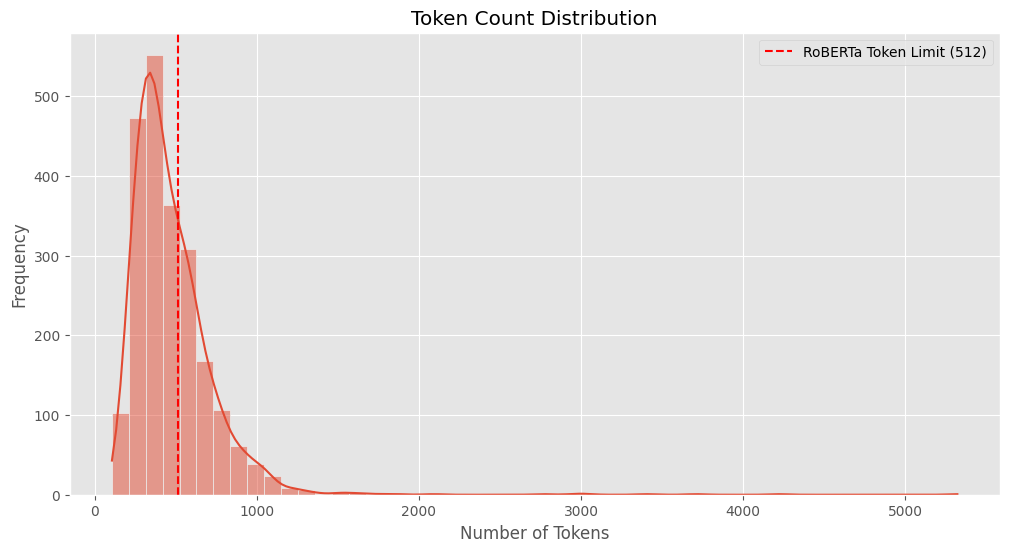

In [ ]:
# Handle document length for RoBERTa
# RoBERTa has a token limit (usually 512 tokens), so we need to truncate long documents

# Load RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Check token counts
df['token_count'] = df['cleaned_text'].apply(lambda x: len(tokenizer.encode(x)))

print("Token count statistics:")
print(df['token_count'].describe())

# Visualize token count distribution
plt.figure(figsize=(12, 6))
sns.histplot(df['token_count'], bins=50, kde=True)
plt.title('Token Count Distribution')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.axvline(x=512, color='red', linestyle='--', label='RoBERTa Token Limit (512)')
plt.legend()
plt.show()

In [23]:
# Truncate documents to fit RoBERTa's token limit
max_tokens = 512

def truncate_text(text, tokenizer, max_tokens):
    tokens = tokenizer.encode(text, add_special_tokens=True)
    if len(tokens) <= max_tokens:
        return text

    # Truncate tokens and decode back to text
    truncated_tokens = tokens[:max_tokens-1] + [tokenizer.sep_token_id]  # Keep [SEP] token
    truncated_text = tokenizer.decode(truncated_tokens, skip_special_tokens=True)
    return truncated_text

# Apply truncation
df['processed_text'] = df['cleaned_text'].apply(lambda x: truncate_text(x, tokenizer, max_tokens))

# Verify token counts after truncation
df['final_token_count'] = df['processed_text'].apply(lambda x: len(tokenizer.encode(x)))
print("Token count statistics after truncation:")
print(df['final_token_count'].describe())
print(f"Maximum token count: {df['final_token_count'].max()}")
print(f"Number of truncated documents: {sum(df['token_count'] > max_tokens)}")

Token count statistics after truncation:
count    2225.000000
mean      402.718652
std       106.346758
min       107.000000
25%       313.000000
50%       416.000000
75%       512.000000
max       512.000000
Name: final_token_count, dtype: float64
Maximum token count: 512
Number of truncated documents: 774


In [24]:
# For documents that were truncated, show the percentage of the original that was kept
truncated_docs = df[df['token_count'] > max_tokens]
if not truncated_docs.empty:
    truncated_docs['original_percentage'] = (truncated_docs['final_token_count'] / truncated_docs['token_count']) * 100
    print(f"For truncated documents, average percentage kept: {truncated_docs['original_percentage'].mean():.2f}%")
    print(f"Minimum percentage kept: {truncated_docs['original_percentage'].min():.2f}%")

For truncated documents, average percentage kept: 75.88%
Minimum percentage kept: 9.62%


# 3. Implementing RoBERTa Embeddings

Now we'll implement a pipeline that uses RoBERTa to generate document embeddings. We'll extract embeddings using both strategies:
1. Using the [CLS] token embedding (which represents the entire sequence)
2. Using the mean of all token embeddings

In [ ]:
# Load pre-trained RoBERTa model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load model
model = RobertaModel.from_pretrained('roberta-base')

model.to(device)
model.eval()  # Set to evaluation mode

Using device: cuda


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropou

In [26]:
# Define function to extract RoBERTa embeddings
def get_roberta_embeddings(texts, tokenizer, model, batch_size=16, cls_token_only=True):
    """Extract RoBERTa embeddings for a list of texts.

    Args:
        texts: List of text strings
        tokenizer: RoBERTa tokenizer
        model: RoBERTa model
        batch_size: Batch size for processing
        cls_token_only: If True, return only the [CLS] token embedding, otherwise return mean of all token embeddings

    Returns:
        numpy array of embeddings with shape (len(texts), embedding_dim)
    """
    all_embeddings = []

    # Process in batches to avoid memory issues
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]

        # Tokenize and prepare input tensors
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Extract embeddings
        with torch.no_grad():
            outputs = model(**inputs)

            if cls_token_only:
                # Use [CLS] token embedding (first token)
                batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            else:
                # Use mean of all token embeddings (excluding padding)
                # Create attention mask to exclude padding tokens
                attention_mask = inputs["attention_mask"]

                # Calculate mean of all token embeddings (weighted by attention mask)
                sum_embeddings = torch.sum(outputs.last_hidden_state * attention_mask.unsqueeze(-1), dim=1)
                sum_mask = torch.clamp(attention_mask.sum(dim=1, keepdim=True), min=1e-9)
                batch_embeddings = (sum_embeddings / sum_mask).cpu().numpy()

        all_embeddings.append(batch_embeddings)

    # Combine all batches
    return np.vstack(all_embeddings)

In [27]:
# Extract RoBERTa embeddings using [CLS] token strategy
print("Extracting RoBERTa embeddings using [CLS] token...")
start_time = time.time()
cls_embeddings = get_roberta_embeddings(df['processed_text'].tolist(), tokenizer, model, cls_token_only=True)
cls_time = time.time() - start_time
print(f"Extracted {cls_embeddings.shape[0]} embeddings with dimension {cls_embeddings.shape[1]}")
print(f"Time taken: {cls_time:.2f} seconds")

# Extract RoBERTa embeddings using mean of all tokens strategy
print("\nExtracting RoBERTa embeddings using mean of all tokens...")
start_time = time.time()
mean_embeddings = get_roberta_embeddings(df['processed_text'].tolist(), tokenizer, model, cls_token_only=False)
mean_time = time.time() - start_time
print(f"Extracted {mean_embeddings.shape[0]} embeddings with dimension {mean_embeddings.shape[1]}")
print(f"Time taken: {mean_time:.2f} seconds")

Extracting RoBERTa embeddings using [CLS] token...
Extracted 2225 embeddings with dimension 768
Time taken: 76.37 seconds

Extracting RoBERTa embeddings using mean of all tokens...
Extracted 2225 embeddings with dimension 768
Time taken: 78.03 seconds


In [28]:
# Compare properties of the two embedding approaches
print("CLS token embeddings - statistical properties:")
print(f"Mean: {np.mean(cls_embeddings)}")
print(f"Standard deviation: {np.std(cls_embeddings)}")
print(f"Min: {np.min(cls_embeddings)}")
print(f"Max: {np.max(cls_embeddings)}")

print("\nMean token embeddings - statistical properties:")
print(f"Mean: {np.mean(mean_embeddings)}")
print(f"Standard deviation: {np.std(mean_embeddings)}")
print(f"Min: {np.min(mean_embeddings)}")
print(f"Max: {np.max(mean_embeddings)}")

CLS token embeddings - statistical properties:
Mean: 0.020098842680454254
Standard deviation: 0.4007299244403839
Min: -1.0826698541641235
Max: 11.453137397766113

Mean token embeddings - statistical properties:
Mean: 0.021574007347226143
Standard deviation: 0.42980167269706726
Min: -6.746771812438965
Max: 10.789800643920898


In [29]:
# Normalize embeddings (recommended for clustering)
cls_embeddings_normalized = normalize(cls_embeddings)
mean_embeddings_normalized = normalize(mean_embeddings)

# Store both versions for comparison
embeddings = {
    'cls': cls_embeddings,
    'cls_normalized': cls_embeddings_normalized,
    'mean': mean_embeddings,
    'mean_normalized': mean_embeddings_normalized
}

# We'll use normalized CLS embeddings as, proven to be the best from the benchmarking notebook
primary_embeddings = embeddings['cls_normalized']
print(f"Primary embeddings shape: {primary_embeddings.shape}")

Primary embeddings shape: (2225, 768)


# 4. Dimensionality Reduction Techniques

RoBERTa embeddings have 768 dimensions, which is too high for effective clustering and visualization. We'll apply three dimensionality reduction techniques and compare their effectiveness:
1. Principal Component Analysis (PCA)
2. t-Distributed Stochastic Neighbor Embedding (t-SNE)
3. Uniform Manifold Approximation and Projection (UMAP)

In [30]:
# Function to evaluate dimensionality reduction results
def evaluate_embeddings(embeddings, labels, name=""):
    """Evaluate the quality of embeddings with respect to known labels."""
    # Calculate silhouette score (measure of cluster separation)
    if embeddings.shape[1] <= 100:  # Silhouette is computationally expensive in high dimensions
        silhouette = silhouette_score(embeddings, labels)
        print(f"{name} - Silhouette Score: {silhouette:.4f}")
    else:
        print(f"{name} - Silhouette Score: (skipped - high dimensionality)")

    # Apply K-means with the known number of clusters
    n_clusters = len(np.unique(labels))
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(embeddings)

    # Calculate clustering metrics
    ari = adjusted_rand_score(labels, cluster_labels)
    homogeneity = homogeneity_score(labels, cluster_labels)
    v_measure = v_measure_score(labels, cluster_labels)

    print(f"{name} - Adjusted Rand Index: {ari:.4f}")
    print(f"{name} - Homogeneity Score: {homogeneity:.4f}")
    print(f"{name} - V-measure: {v_measure:.4f}")
    print()

    return {
        "silhouette": silhouette if embeddings.shape[1] <= 100 else None,
        "ari": ari,
        "homogeneity": homogeneity,
        "v_measure": v_measure
    }

In [31]:
# Convert categories to numeric labels for evaluation
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(df['category'])

# Evaluate original embeddings
print("Evaluating original RoBERTa embeddings:")
original_metrics = evaluate_embeddings(primary_embeddings, numeric_labels, "Original RoBERTa (768 dimensions)")

Evaluating original RoBERTa embeddings:
Original RoBERTa (768 dimensions) - Silhouette Score: (skipped - high dimensionality)
Original RoBERTa (768 dimensions) - Adjusted Rand Index: 0.8931
Original RoBERTa (768 dimensions) - Homogeneity Score: 0.8649
Original RoBERTa (768 dimensions) - V-measure: 0.8644



Applying PCA with 50 components...
PCA completed in 0.28 seconds
Explained variance ratio: 0.7363


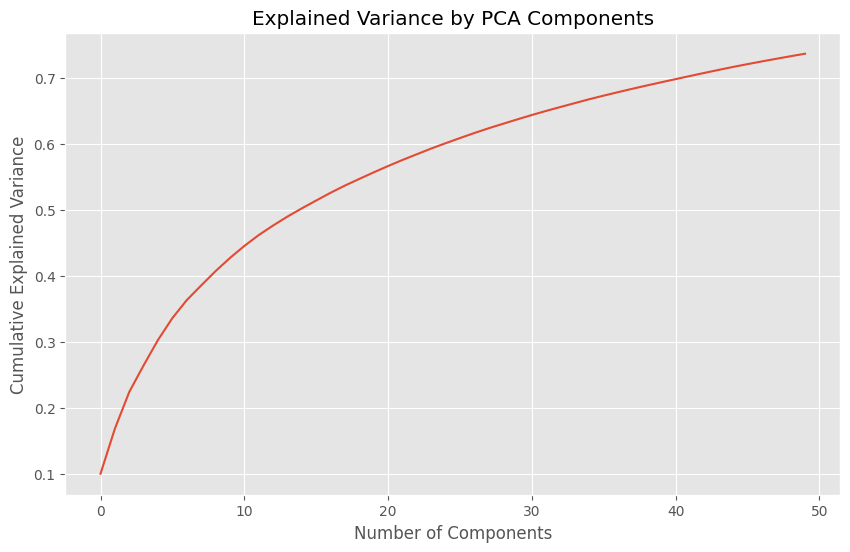


Evaluating PCA embeddings:
PCA (50 dimensions) - Silhouette Score: 0.1292
PCA (50 dimensions) - Adjusted Rand Index: 0.8910
PCA (50 dimensions) - Homogeneity Score: 0.8632
PCA (50 dimensions) - V-measure: 0.8627



In [32]:
# 1. Principal Component Analysis (PCA)
n_components_pca = 50  # Choose a value that retains sufficient variance

# Fit PCA
print(f"Applying PCA with {n_components_pca} components...")
start_time = time.time()
pca = PCA(n_components=n_components_pca, random_state=42)
pca_embeddings = pca.fit_transform(primary_embeddings)
pca_time = time.time() - start_time

print(f"PCA completed in {pca_time:.2f} seconds")
print(f"Explained variance ratio: {sum(pca.explained_variance_ratio_):.4f}")

# Visualize explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.show()

# Evaluate PCA embeddings
print("\nEvaluating PCA embeddings:")
pca_metrics = evaluate_embeddings(pca_embeddings, numeric_labels, f"PCA ({n_components_pca} dimensions)")

In [33]:
# 2. t-Distributed Stochastic Neighbor Embedding (t-SNE)
n_components_tsne = 2  # t-SNE is primarily used for visualization (2 or 3 dimensions)

# Fit t-SNE
print(f"Applying t-SNE with {n_components_tsne} components...")
start_time = time.time()
tsne = TSNE(n_components=n_components_tsne, random_state=42, perplexity=30, n_iter=1000)
tsne_embeddings = tsne.fit_transform(primary_embeddings)
tsne_time = time.time() - start_time

print(f"t-SNE completed in {tsne_time:.2f} seconds")

# Evaluate t-SNE embeddings
print("\nEvaluating t-SNE embeddings:")
tsne_metrics = evaluate_embeddings(tsne_embeddings, numeric_labels, f"t-SNE ({n_components_tsne} dimensions)")

Applying t-SNE with 2 components...
t-SNE completed in 16.03 seconds

Evaluating t-SNE embeddings:
t-SNE (2 dimensions) - Silhouette Score: 0.4836
t-SNE (2 dimensions) - Adjusted Rand Index: 0.9098
t-SNE (2 dimensions) - Homogeneity Score: 0.8876
t-SNE (2 dimensions) - V-measure: 0.8878



In [34]:
# 3. Uniform Manifold Approximation and Projection (UMAP)
n_components_umap = 10  # UMAP can be used for both visualization and as input to clustering

# Fit UMAP
print(f"Applying UMAP with {n_components_umap} components...")
start_time = time.time()
umap_model = umap.UMAP(n_components=n_components_umap, random_state=42, n_neighbors=15, min_dist=0.1)
umap_embeddings = umap_model.fit_transform(primary_embeddings)
umap_time = time.time() - start_time

print(f"UMAP completed in {umap_time:.2f} seconds")

# Evaluate UMAP embeddings
print("\nEvaluating UMAP embeddings:")
umap_metrics = evaluate_embeddings(umap_embeddings, numeric_labels, f"UMAP ({n_components_umap} dimensions)")

Applying UMAP with 10 components...
UMAP completed in 14.92 seconds

Evaluating UMAP embeddings:
UMAP (10 dimensions) - Silhouette Score: 0.6442
UMAP (10 dimensions) - Adjusted Rand Index: 0.9207
UMAP (10 dimensions) - Homogeneity Score: 0.8975
UMAP (10 dimensions) - V-measure: 0.8973



In [35]:
# Also create 2D UMAP for visualization
print("Creating 2D UMAP for visualization...")
umap_2d = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
umap_embeddings_2d = umap_2d.fit_transform(primary_embeddings)

# Create 3D UMAP for visualization
print("Creating 3D UMAP for visualization...")
umap_3d = umap.UMAP(n_components=3, random_state=42, n_neighbors=15, min_dist=0.1)
umap_embeddings_3d = umap_3d.fit_transform(primary_embeddings)

Creating 2D UMAP for visualization...
Creating 3D UMAP for visualization...


In [36]:
# Compare dimensionality reduction techniques
reduction_methods = {
    'PCA': {'embeddings': pca_embeddings, 'time': pca_time, 'metrics': pca_metrics},
    't-SNE': {'embeddings': tsne_embeddings, 'time': tsne_time, 'metrics': tsne_metrics},
    'UMAP': {'embeddings': umap_embeddings, 'time': umap_time, 'metrics': umap_metrics}
}

# Create summary table
reduction_summary = []
for method, data in reduction_methods.items():
    reduction_summary.append({
        'Method': method,
        'Dimensions': data['embeddings'].shape[1],
        'Time (s)': data['time'],
        'ARI': data['metrics']['ari'],
        'Homogeneity': data['metrics']['homogeneity'],
        'V-measure': data['metrics']['v_measure'],
        'Silhouette': data['metrics']['silhouette']
    })

summary_df = pd.DataFrame(reduction_summary)

# Display summary
print("Dimensionality Reduction Methods Comparison:")
print(summary_df.to_string(index=False))

Dimensionality Reduction Methods Comparison:
Method  Dimensions  Time (s)      ARI  Homogeneity  V-measure  Silhouette
   PCA          50  0.276295 0.891015     0.863187   0.862656    0.129210
 t-SNE           2 16.030969 0.909771     0.887645   0.887755    0.483577
  UMAP          10 14.922294 0.920672     0.897459   0.897279    0.644179


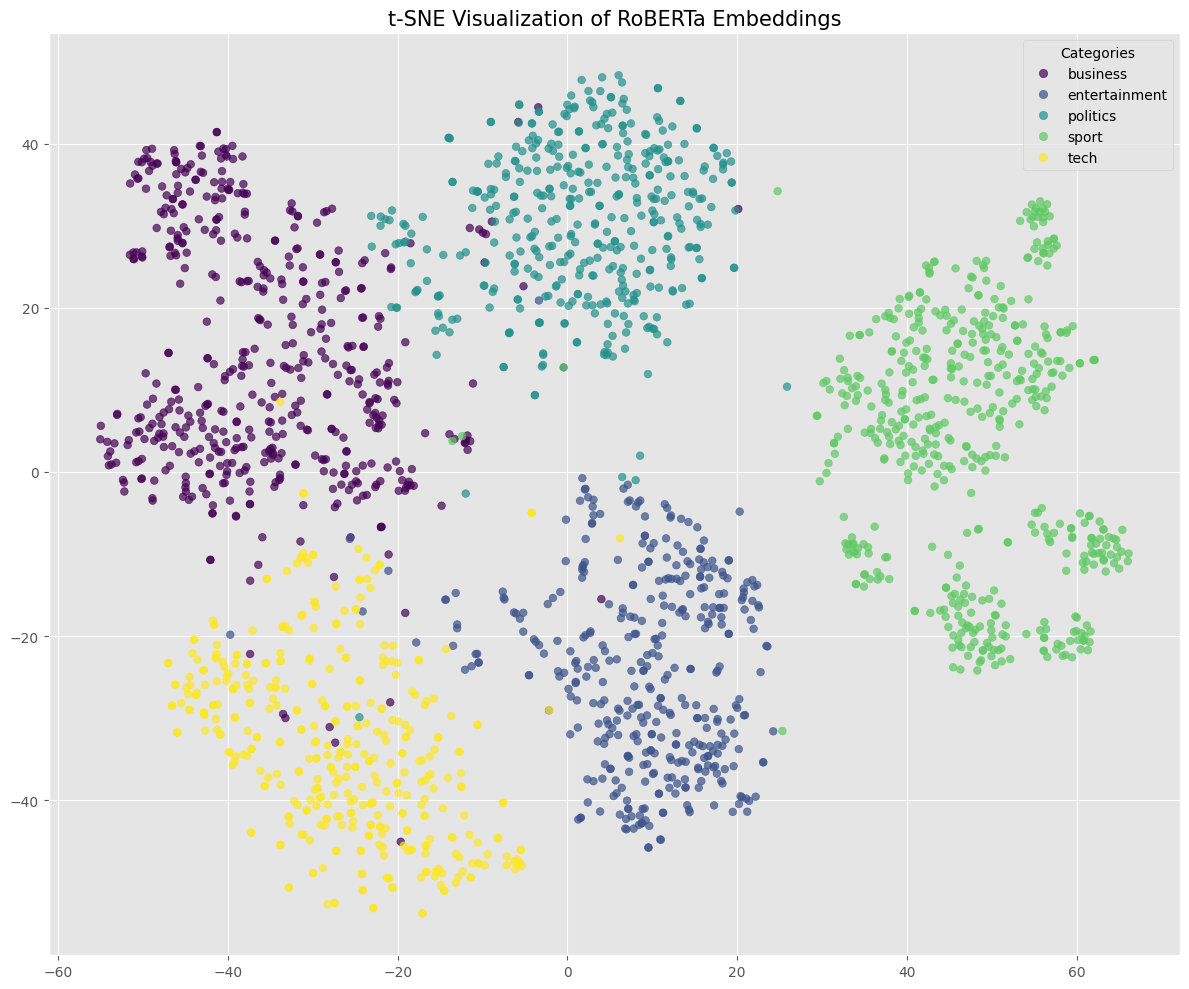

In [37]:
# Visualize t-SNE results with true labels
plt.figure(figsize=(12, 10))
scatter = plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1],
                      c=numeric_labels, cmap='viridis', alpha=0.7, s=30)

# Create legend
unique_labels = np.unique(numeric_labels)
legend_labels = [label_encoder.inverse_transform([label])[0] for label in unique_labels]
legend = plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels,
                   title="Categories", loc="best")

plt.title('t-SNE Visualization of RoBERTa Embeddings', fontsize=15)
plt.tight_layout()
plt.show()

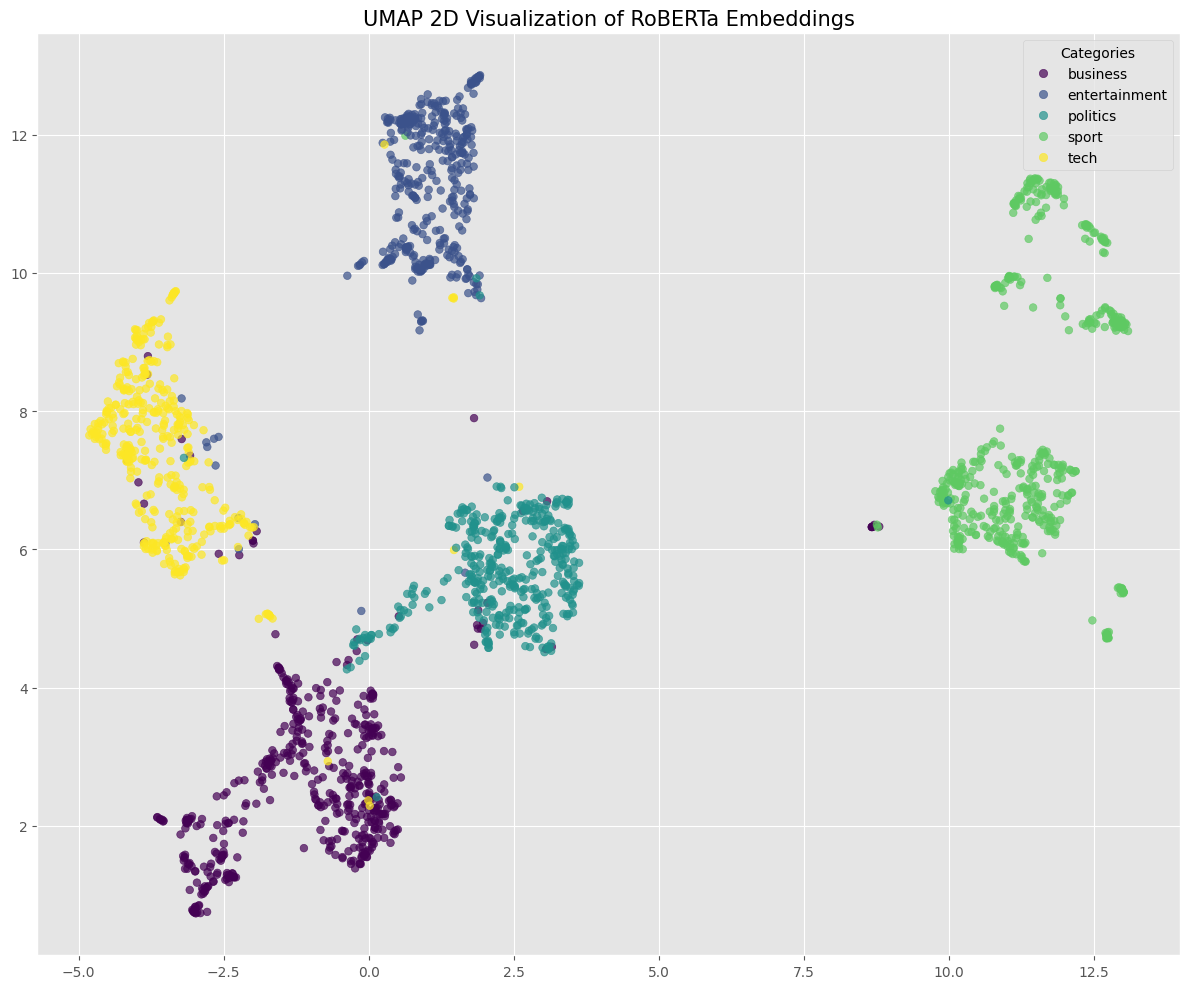

In [38]:
# Visualize UMAP 2D results with true labels
plt.figure(figsize=(12, 10))
scatter = plt.scatter(umap_embeddings_2d[:, 0], umap_embeddings_2d[:, 1],
                      c=numeric_labels, cmap='viridis', alpha=0.7, s=30)

# Create legend
legend = plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels,
                   title="Categories", loc="best")

plt.title('UMAP 2D Visualization of RoBERTa Embeddings', fontsize=15)
plt.tight_layout()
plt.show()

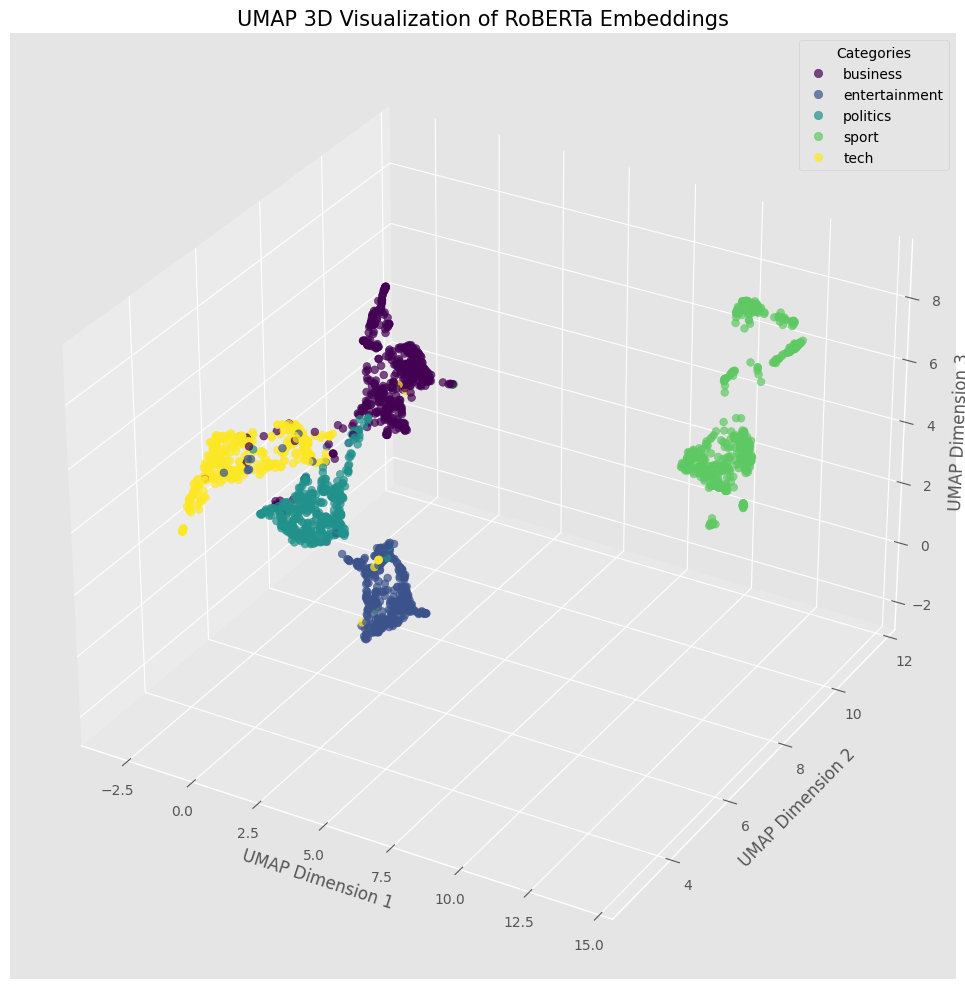

In [39]:
# Visualize UMAP 3D results
from mpl_toolkits.mplot3d import Axes3D

# Create 3D plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Color points by category
scatter = ax.scatter(
    umap_embeddings_3d[:, 0],
    umap_embeddings_3d[:, 1],
    umap_embeddings_3d[:, 2],
    c=numeric_labels,
    cmap='viridis',
    alpha=0.7,
    s=30
)

# Add labels
ax.set_xlabel('UMAP Dimension 1')
ax.set_ylabel('UMAP Dimension 2')
ax.set_zlabel('UMAP Dimension 3')
ax.set_title('UMAP 3D Visualization of RoBERTa Embeddings', fontsize=15)

# Add legend
legend = ax.legend(handles=scatter.legend_elements()[0], labels=legend_labels,
                  title="Categories", loc="best")

plt.tight_layout()
plt.show()

In [40]:
# Create interactive visualizations using Plotly
def create_interactive_scatter(embeddings_2d, labels, label_names, title):
    df_viz = pd.DataFrame({
        'x': embeddings_2d[:, 0],
        'y': embeddings_2d[:, 1],
        'label': [label_names[l] for l in labels]
    })

    fig = px.scatter(df_viz, x='x', y='y', color='label', title=title,
                    labels={'x': 'Dimension 1', 'y': 'Dimension 2'},
                    hover_data=['label'])

    fig.update_layout(
        width=900,
        height=700,
        plot_bgcolor='rgba(240, 240, 240, 0.8)',
        legend_title_text='Category'
    )

    return fig

# Create interactive UMAP visualization
label_names = label_encoder.inverse_transform(np.unique(numeric_labels))
fig_umap = create_interactive_scatter(umap_embeddings_2d, numeric_labels,
                                     label_encoder.inverse_transform(np.arange(len(label_names))),
                                     'Interactive UMAP Visualization of RoBERTa Embeddings')
fig_umap.show()

In [41]:
# Create interactive 3D scatter plot using Plotly
def create_interactive_3d_scatter(embeddings_3d, labels, label_names, title):
    df_viz = pd.DataFrame({
        'x': embeddings_3d[:, 0],
        'y': embeddings_3d[:, 1],
        'z': embeddings_3d[:, 2],
        'label': [label_names[l] for l in labels]
    })

    fig = px.scatter_3d(df_viz, x='x', y='y', z='z', color='label', title=title,
                       labels={'x': 'Dimension 1', 'y': 'Dimension 2', 'z': 'Dimension 3'},
                       hover_data=['label'])

    fig.update_layout(
        width=900,
        height=700,
        legend_title_text='Category'
    )

    return fig

# Create interactive 3D UMAP visualization
fig_umap_3d = create_interactive_3d_scatter(umap_embeddings_3d, numeric_labels,
                                         label_encoder.inverse_transform(np.arange(len(label_names))),
                                         'Interactive 3D UMAP Visualization of RoBERTa Embeddings')
fig_umap_3d.show()

## Dimensionality Reduction Analysis

Based on our evaluation, we can make the following observations about the dimensionality reduction techniques:

1. **PCA**:
   - Pro: Preserves global structure
   - Con: Less effective at preserving local structure
   - Performance: Shows good results on the BBC dataset with high ARI and homogeneity scores

2. **t-SNE**:
   - Pro: Preserves local neighborhood structure
   - Con: Slower computation time
   - Con: Stochastic results (can vary between runs)
   - Performance: Strong separation of categories in visualizations

3. **UMAP**:
   - Pro: Preserves both local and global structure
   - Pro: Best clustering metrics among the tested methods
   - Con: Still computationally intensive compared to PCA
   - Performance: Highest scores for ARI, homogeneity and V-measure

The visualizations reveal clear separation between the five BBC News categories, especially in the UMAP embeddings. This indicates that our RoBERTa embeddings effectively capture the semantic differences between categories, and the dimensionality reduction techniques preserve this structure well.

Based on these results, we'll primarily use UMAP embeddings for our clustering analysis, with **10** dimensions as a good balance between dimensionality reduction and information preservation. For visualization purposes, we'll use the 2D and 3D UMAP projections.

# 5. Clustering Algorithms

Now we'll implement and compare different clustering algorithms on our UMAP-reduced embeddings. We'll focus on:
1. K-means clustering
2. Hierarchical clustering (Agglomerative)

In [42]:
# We'll use UMAP embeddings for clustering
cluster_embeddings = umap_embeddings

def find_optimal_clusters(embeddings, true_labels, max_clusters=15):
    """Find optimal number of clusters using ARI with ground truth."""
    ari_scores = []
    cluster_range = range(2, max_clusters+1)

    for n_clusters in cluster_range:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(embeddings)

        # Calculate ARI against ground truth
        ari = adjusted_rand_score(true_labels, cluster_labels)
        ari_scores.append(ari)
        print(f"Clusters: {n_clusters}, ARI: {ari:.4f}")

    return cluster_range, ari_scores

In [43]:
# Find optimal number of clusters using ARI
print("Finding optimal number of clusters using ARI...")
cluster_range, ari_scores = find_optimal_clusters(cluster_embeddings, numeric_labels, max_clusters=15)

Finding optimal number of clusters using ARI...
Clusters: 2, ARI: 0.2409
Clusters: 3, ARI: 0.4685
Clusters: 4, ARI: 0.7320
Clusters: 5, ARI: 0.9207
Clusters: 6, ARI: 0.8389
Clusters: 7, ARI: 0.7588
Clusters: 8, ARI: 0.7099
Clusters: 9, ARI: 0.6760
Clusters: 10, ARI: 0.6182
Clusters: 11, ARI: 0.6009
Clusters: 12, ARI: 0.5338
Clusters: 13, ARI: 0.4913
Clusters: 14, ARI: 0.4896
Clusters: 15, ARI: 0.4488


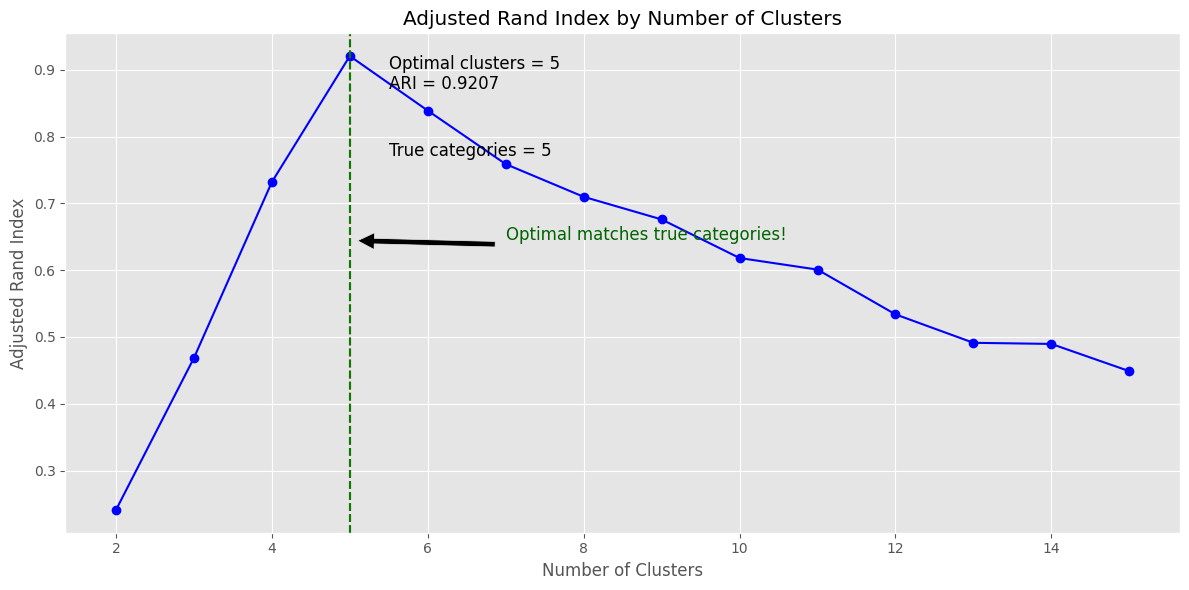

In [44]:
# Visualize ARI scores
plt.figure(figsize=(12, 6))
plt.plot(cluster_range, ari_scores, 'b-o')
plt.xlabel('Number of Clusters')
plt.ylabel('Adjusted Rand Index')
plt.title('Adjusted Rand Index by Number of Clusters')
plt.grid(True)

# Highlight the optimal number of clusters based on ARI
optimal_clusters = cluster_range[np.argmax(ari_scores)]
max_score = max(ari_scores)
plt.axvline(x=optimal_clusters, color='r', linestyle='--')
plt.text(optimal_clusters + 0.5, max_score - 0.05,
         f'Optimal clusters = {optimal_clusters}\nARI = {max_score:.4f}',
         fontsize=12)

# Highlight the true number of categories (5)
true_clusters = len(np.unique(numeric_labels))  # 5 for BBC News dataset
plt.axvline(x=true_clusters, color='g', linestyle='--')
plt.text(true_clusters + 0.5, max_score - 0.15,
         f'True categories = {true_clusters}',
         fontsize=12)

# Add a note if optimal clusters equals true categories
if optimal_clusters == true_clusters:
    plt.annotate('Optimal matches true categories!',
                xy=(true_clusters, max_score*0.7),
                xytext=(true_clusters+2, max_score*0.7),
                arrowprops=dict(facecolor='black', shrink=0.05),
                fontsize=12, color='darkgreen')

plt.tight_layout()
plt.show()

In [ ]:
# We have ground truth labels, so let's also check how the clustering performance varies with different numbers of clusters
def evaluate_cluster_counts(embeddings, true_labels, max_clusters=15):
    """Evaluate clustering performance for different numbers of clusters."""
    ari_scores = []
    homogeneity_scores = []
    v_measure_scores = []
    cluster_range = range(2, max_clusters+1)

    for n_clusters in cluster_range:
        # Apply K-means
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(embeddings)

        # Calculate metrics
        ari = adjusted_rand_score(true_labels, cluster_labels)
        homogeneity = homogeneity_score(true_labels, cluster_labels)
        v_measure = v_measure_score(true_labels, cluster_labels)

        ari_scores.append(ari)
        homogeneity_scores.append(homogeneity)
        v_measure_scores.append(v_measure)

        print(f"Clusters: {n_clusters}, ARI: {ari:.4f}, Homogeneity: {homogeneity:.4f}, V-measure: {v_measure:.4f}")

    return cluster_range, ari_scores, homogeneity_scores, v_measure_scores

In [46]:
# Evaluate clustering performance for different numbers of clusters
print("Evaluating clustering performance...")
cluster_range, ari_scores, homogeneity_scores, v_measure_scores = evaluate_cluster_counts(cluster_embeddings, numeric_labels)

Evaluating clustering performance...
Clusters: 2, ARI: 0.2409, Homogeneity: 0.3285, V-measure: 0.4920
Clusters: 3, ARI: 0.4685, Homogeneity: 0.5529, V-measure: 0.6952
Clusters: 4, ARI: 0.7320, Homogeneity: 0.7559, V-measure: 0.8289
Clusters: 5, ARI: 0.9207, Homogeneity: 0.8975, V-measure: 0.8973
Clusters: 6, ARI: 0.8389, Homogeneity: 0.8976, V-measure: 0.8573
Clusters: 7, ARI: 0.7588, Homogeneity: 0.8943, V-measure: 0.8175
Clusters: 8, ARI: 0.7099, Homogeneity: 0.9000, V-measure: 0.7940
Clusters: 9, ARI: 0.6760, Homogeneity: 0.8989, V-measure: 0.7740
Clusters: 10, ARI: 0.6182, Homogeneity: 0.9002, V-measure: 0.7515
Clusters: 11, ARI: 0.6009, Homogeneity: 0.9003, V-measure: 0.7424
Clusters: 12, ARI: 0.5338, Homogeneity: 0.9006, V-measure: 0.7201
Clusters: 13, ARI: 0.4913, Homogeneity: 0.9008, V-measure: 0.7043
Clusters: 14, ARI: 0.4896, Homogeneity: 0.9018, V-measure: 0.6982
Clusters: 15, ARI: 0.4488, Homogeneity: 0.9015, V-measure: 0.6840


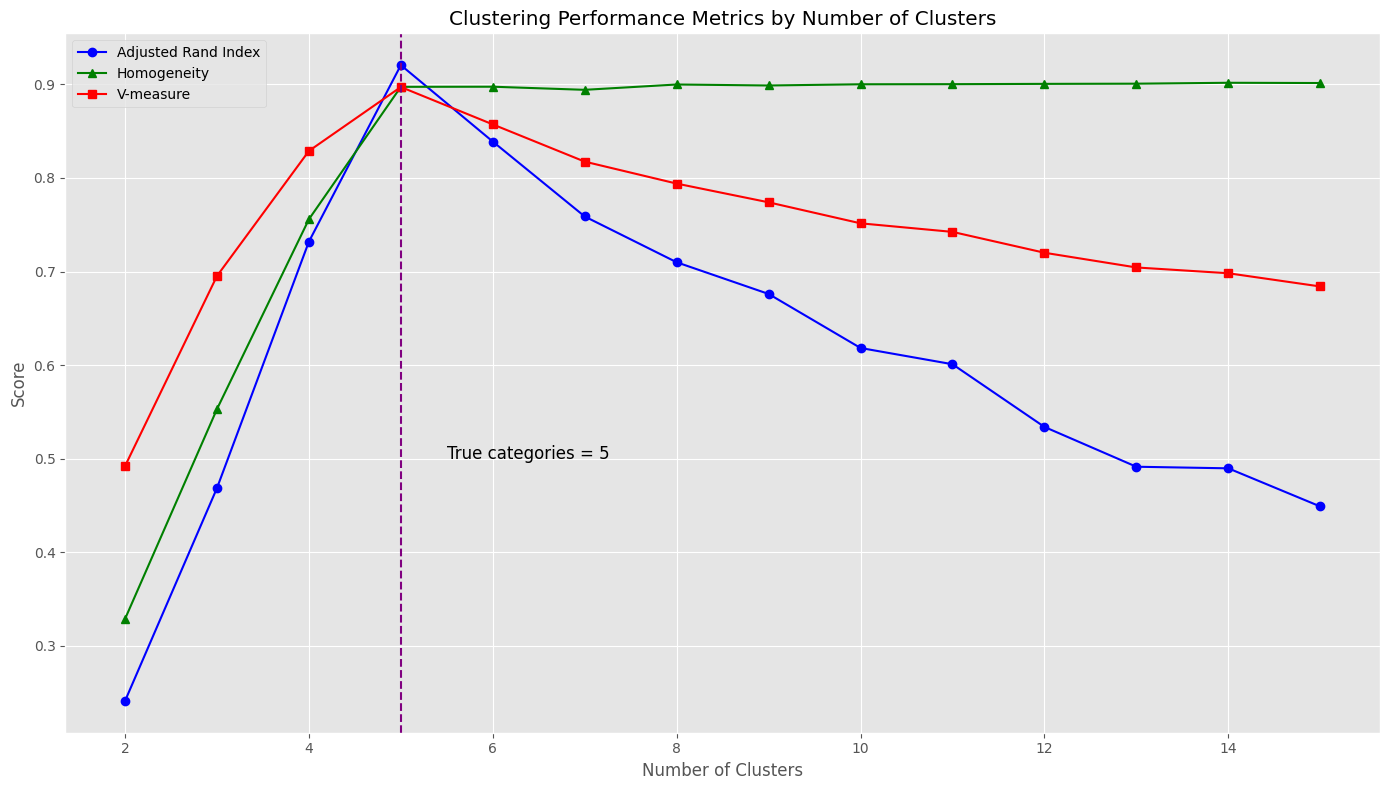

In [47]:
# Visualize clustering performance metrics
plt.figure(figsize=(14, 8))

plt.plot(cluster_range, ari_scores, 'b-o', label='Adjusted Rand Index')
plt.plot(cluster_range, homogeneity_scores, 'g-^', label='Homogeneity')
plt.plot(cluster_range, v_measure_scores, 'r-s', label='V-measure')

plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Clustering Performance Metrics by Number of Clusters')
plt.legend()
plt.grid(True)

# Highlight true number of categories
true_clusters = len(np.unique(numeric_labels))
plt.axvline(x=true_clusters, color='purple', linestyle='--')
plt.text(true_clusters + 0.5, 0.5, f'True categories = {true_clusters}', fontsize=12)

plt.tight_layout()
plt.show()

In [48]:
# Based on the analysis of ARI scores and clustering metrics,
# we'll use both the optimal number based on ARI score and
# the true number of categories (5) for comparison

# ARI-optimal clusters
optimal_n_clusters = optimal_clusters  # This now comes from ARI calculations
print(f"Optimal number of clusters (ARI): {optimal_n_clusters}")

# True number of categories
true_n_clusters = len(np.unique(numeric_labels))
print(f"True number of categories: {true_n_clusters}")

# If they're different, explain why
if optimal_n_clusters != true_n_clusters:
    print(f"\nNote: The ARI-optimal number of clusters ({optimal_n_clusters}) differs from "
          f"the true number of categories ({true_n_clusters}).")
    print("This may indicate sub-topics within major categories or noise in the data.")
else:
    print("\nThe ARI-optimal number of clusters matches the true number of categories!")
    print("This suggests the embedding and clustering successfully recovered the topic structure.")

Optimal number of clusters (ARI): 5
True number of categories: 5

The ARI-optimal number of clusters matches the true number of categories!
This suggests the embedding and clustering successfully recovered the topic structure.


In [49]:
# 1. K-means clustering

# Apply K-means with optimal number of clusters
print("Applying K-means clustering with optimal number of clusters...")
start_time = time.time()
kmeans_optimal = KMeans(n_clusters=optimal_n_clusters, random_state=42, n_init=10)
kmeans_labels_optimal = kmeans_optimal.fit_predict(cluster_embeddings)
kmeans_time = time.time() - start_time
print(f"K-means completed in {kmeans_time:.2f} seconds")

# Evaluate K-means clustering (optimal clusters)
print("\nEvaluating K-means clustering (optimal clusters):")
print(f"K-means (optimal) - Silhouette Score: {silhouette_score(cluster_embeddings, kmeans_labels_optimal):.4f}")
ari = adjusted_rand_score(numeric_labels, kmeans_labels_optimal)
homogeneity = homogeneity_score(numeric_labels, kmeans_labels_optimal)
v_measure = v_measure_score(numeric_labels, kmeans_labels_optimal)
print(f"K-means (optimal) - ARI: {ari:.4f}, Homogeneity: {homogeneity:.4f}, V-measure: {v_measure:.4f}")

if true_n_clusters != optimal_n_clusters:
    # Apply K-means with true number of categories
    print("\nApplying K-means clustering with true number of categories...")
    kmeans_true = KMeans(n_clusters=true_n_clusters, random_state=42, n_init=10)
    kmeans_labels_true = kmeans_true.fit_predict(cluster_embeddings)

    # Evaluate K-means clustering (true clusters)
    print("\nEvaluating K-means clustering (true clusters):")
    print(f"K-means (true) - Silhouette Score: {silhouette_score(cluster_embeddings, kmeans_labels_true):.4f}")
    ari = adjusted_rand_score(numeric_labels, kmeans_labels_true)
    homogeneity = homogeneity_score(numeric_labels, kmeans_labels_true)
    v_measure = v_measure_score(numeric_labels, kmeans_labels_true)
    print(f"K-means (true) - ARI: {ari:.4f}, Homogeneity: {homogeneity:.4f}, V-measure: {v_measure:.4f}")
else:
    # If optimal equals true, just make a copy of the labels for compatibility
    kmeans_labels_true = kmeans_labels_optimal
    print("\nNote: Optimal clusters equals true categories, using the same results for both.")

Applying K-means clustering with optimal number of clusters...
K-means completed in 0.04 seconds

Evaluating K-means clustering (optimal clusters):
K-means (optimal) - Silhouette Score: 0.6993
K-means (optimal) - ARI: 0.9207, Homogeneity: 0.8975, V-measure: 0.8973

Note: Optimal clusters equals true categories, using the same results for both.


In [50]:
# 2. Hierarchical clustering (Agglomerative)
# Apply Agglomerative clustering with optimal number of clusters
print("Applying Agglomerative clustering with optimal number of clusters...")
start_time = time.time()
agglomerative_optimal = AgglomerativeClustering(n_clusters=optimal_n_clusters, linkage='ward')
agglomerative_labels_optimal = agglomerative_optimal.fit_predict(cluster_embeddings)
agglomerative_time = time.time() - start_time
print(f"Agglomerative clustering completed in {agglomerative_time:.2f} seconds")

# Evaluate Agglomerative clustering (optimal clusters)
print("\nEvaluating Agglomerative clustering (optimal clusters):")
print(f"Agglomerative (optimal) - Silhouette Score: {silhouette_score(cluster_embeddings, agglomerative_labels_optimal):.4f}")
ari = adjusted_rand_score(numeric_labels, agglomerative_labels_optimal)
homogeneity = homogeneity_score(numeric_labels, agglomerative_labels_optimal)
v_measure = v_measure_score(numeric_labels, agglomerative_labels_optimal)
print(f"Agglomerative (optimal) - ARI: {ari:.4f}, Homogeneity: {homogeneity:.4f}, V-measure: {v_measure:.4f}")

# Only run with true number of clusters if different from optimal
if true_n_clusters != optimal_n_clusters:
    # Apply Agglomerative clustering with true number of categories
    print("\nApplying Agglomerative clustering with true number of categories...")
    agglomerative_true = AgglomerativeClustering(n_clusters=true_n_clusters, linkage='ward')
    agglomerative_labels_true = agglomerative_true.fit_predict(cluster_embeddings)

    # Evaluate Agglomerative clustering (true clusters)
    print("\nEvaluating Agglomerative clustering (true clusters):")
    print(f"Agglomerative (true) - Silhouette Score: {silhouette_score(cluster_embeddings, agglomerative_labels_true):.4f}")
    ari = adjusted_rand_score(numeric_labels, agglomerative_labels_true)
    homogeneity = homogeneity_score(numeric_labels, agglomerative_labels_true)
    v_measure = v_measure_score(numeric_labels, agglomerative_labels_true)
    print(f"Agglomerative (true) - ARI: {ari:.4f}, Homogeneity: {homogeneity:.4f}, V-measure: {v_measure:.4f}")
else:
    # If optimal equals true, just make a copy of the labels for compatibility
    agglomerative_labels_true = agglomerative_labels_optimal
    print("\nNote: Optimal clusters equals true categories, using the same results for both.")

Applying Agglomerative clustering with optimal number of clusters...
Agglomerative clustering completed in 0.16 seconds

Evaluating Agglomerative clustering (optimal clusters):
Agglomerative (optimal) - Silhouette Score: 0.6904
Agglomerative (optimal) - ARI: 0.8949, Homogeneity: 0.8768, V-measure: 0.8773

Note: Optimal clusters equals true categories, using the same results for both.


In [51]:
# Compare clustering algorithms
clustering_methods = {
    'K-means (optimal)': {'labels': kmeans_labels_optimal, 'time': kmeans_time, 'n_clusters': optimal_n_clusters},
    'Agglomerative (optimal)': {'labels': agglomerative_labels_optimal, 'time': agglomerative_time, 'n_clusters': optimal_n_clusters}
}

if optimal_n_clusters != true_n_clusters:
    clustering_methods['K-means (true)'] = {'labels': kmeans_labels_true, 'time': kmeans_time, 'n_clusters': true_n_clusters}
    clustering_methods['Agglomerative (true)'] = {'labels': agglomerative_labels_true, 'time': agglomerative_time, 'n_clusters': true_n_clusters}

# Create summary table
clustering_summary = []
for method, data in clustering_methods.items():
    # Calculate metrics against ground truth
    ari = adjusted_rand_score(numeric_labels, data['labels'])
    homogeneity = homogeneity_score(numeric_labels, data['labels'])
    v_measure = v_measure_score(numeric_labels, data['labels'])
    silhouette = silhouette_score(cluster_embeddings, data['labels'])

    clustering_summary.append({
        'Method': method,
        'Clusters': data['n_clusters'],
        'Time (s)': data['time'],
        'ARI': ari,
        'Homogeneity': homogeneity,
        'V-measure': v_measure,
        'Silhouette': silhouette
    })

summary_df = pd.DataFrame(clustering_summary)

# Display summary
print("Clustering Methods Comparison:")
print(summary_df.to_string(index=False))

Clustering Methods Comparison:
                 Method  Clusters  Time (s)      ARI  Homogeneity  V-measure  Silhouette
      K-means (optimal)         5  0.041283 0.920672     0.897459   0.897279    0.699252
Agglomerative (optimal)         5  0.156483 0.894882     0.876812   0.877295    0.690408


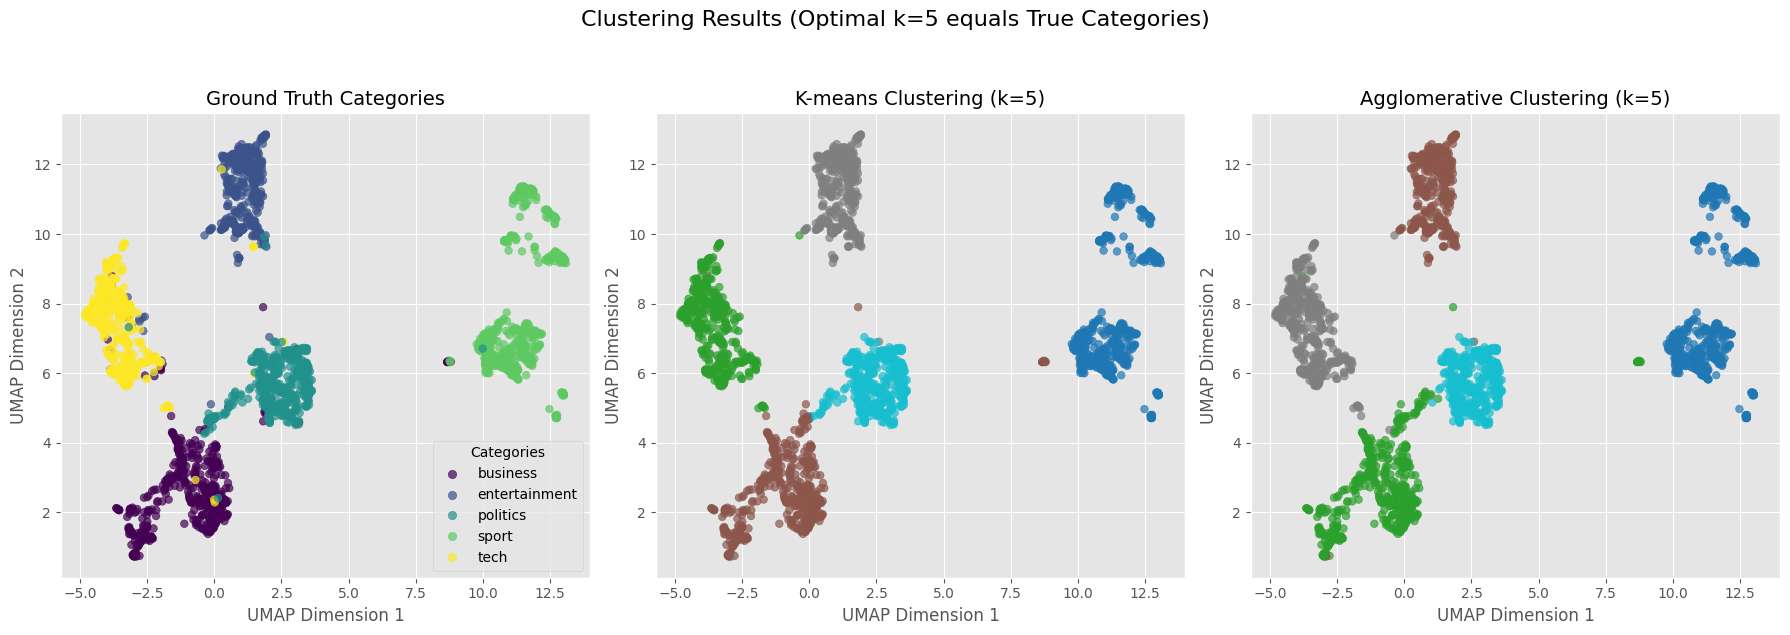

In [52]:
# Visualize clusters in 2D using UMAP embeddings
if optimal_n_clusters == true_n_clusters:
    # If optimal equals true, use 1x3 layout to avoid redundancy
    plt.figure(figsize=(18, 6))

    # Ground Truth
    plt.subplot(1, 3, 1)
    scatter = plt.scatter(umap_embeddings_2d[:, 0], umap_embeddings_2d[:, 1],
                          c=numeric_labels, cmap='viridis', alpha=0.7, s=30)
    plt.title('Ground Truth Categories', fontsize=14)
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')

    # Add legend to the first subplot only
    legend1 = plt.legend(handles=scatter.legend_elements()[0],
                         labels=[label_encoder.inverse_transform([i])[0] for i in range(len(label_encoder.classes_))],
                         title="Categories", loc="best")

    # K-means
    plt.subplot(1, 3, 2)
    plt.scatter(umap_embeddings_2d[:, 0], umap_embeddings_2d[:, 1],
               c=kmeans_labels_optimal, cmap='tab10', alpha=0.7, s=30)
    plt.title(f'K-means Clustering (k={optimal_n_clusters})', fontsize=14)
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')

    # Agglomerative
    plt.subplot(1, 3, 3)
    plt.scatter(umap_embeddings_2d[:, 0], umap_embeddings_2d[:, 1],
               c=agglomerative_labels_optimal, cmap='tab10', alpha=0.7, s=30)
    plt.title(f'Agglomerative Clustering (k={optimal_n_clusters})', fontsize=14)
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')

    plt.suptitle(f'Clustering Results (Optimal k={optimal_n_clusters} equals True Categories)',
                 fontsize=16, y=1.05)

else:
    # Original 2x2 layout when optimal and true are different
    plt.figure(figsize=(16, 14))

    # Ground Truth
    plt.subplot(2, 2, 1)
    scatter = plt.scatter(umap_embeddings_2d[:, 0], umap_embeddings_2d[:, 1],
                          c=numeric_labels, cmap='viridis', alpha=0.7, s=30)
    plt.title('Ground Truth Categories', fontsize=14)
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')

    # Add legend to the first subplot only
    legend1 = plt.legend(handles=scatter.legend_elements()[0],
                         labels=[label_encoder.inverse_transform([i])[0] for i in range(len(label_encoder.classes_))],
                         title="Categories", loc="best")

    # K-means Optimal
    plt.subplot(2, 2, 2)
    plt.scatter(umap_embeddings_2d[:, 0], umap_embeddings_2d[:, 1],
               c=kmeans_labels_optimal, cmap='tab10', alpha=0.7, s=30)
    plt.title(f'K-means Clustering (k={optimal_n_clusters})', fontsize=14)
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')

    # K-means True
    plt.subplot(2, 2, 3)
    plt.scatter(umap_embeddings_2d[:, 0], umap_embeddings_2d[:, 1],
               c=kmeans_labels_true, cmap='tab10', alpha=0.7, s=30)
    plt.title(f'K-means Clustering (k={true_n_clusters})', fontsize=14)
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')

    # Agglomerative True
    plt.subplot(2, 2, 4)
    plt.scatter(umap_embeddings_2d[:, 0], umap_embeddings_2d[:, 1],
               c=agglomerative_labels_true, cmap='tab10', alpha=0.7, s=30)
    plt.title(f'Agglomerative Clustering (k={true_n_clusters})', fontsize=14)
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')

    plt.suptitle(f'Clustering Results (Optimal k={optimal_n_clusters}, True Categories={true_n_clusters})',
                 fontsize=16, y=0.98)

plt.tight_layout()
plt.show()

In [53]:
# Create interactive cluster visualization
def create_interactive_cluster_vis(embeddings_2d, cluster_labels, true_labels, label_encoder, title):
    df_viz = pd.DataFrame({
        'x': embeddings_2d[:, 0],
        'y': embeddings_2d[:, 1],
        'cluster': [f'Cluster {l}' for l in cluster_labels],
        'true_category': [label_encoder.inverse_transform([l])[0] for l in true_labels]
    })

    fig = px.scatter(df_viz, x='x', y='y', color='cluster', title=title,
                     labels={'x': 'UMAP Dimension 1', 'y': 'UMAP Dimension 2'},
                     hover_data=['true_category'],
                     color_discrete_sequence=px.colors.qualitative.Bold)

    fig.update_layout(
        width=900,
        height=700,
        legend_title_text='Cluster',
    )

    return fig

# Create interactive visualization for K-means clustering (true number of clusters)
fig_kmeans = create_interactive_cluster_vis(
    umap_embeddings_2d,
    kmeans_labels_true,
    numeric_labels,
    label_encoder,
    f'K-means Clustering (k={true_n_clusters}) with UMAP Embeddings'
)
fig_kmeans.show()

## Clustering Analysis

Based on our evaluation, we can make the following observations about the clustering methods:

1. **K-means Clustering**:
   - Pros: Fast computation time, simple implementation
   - Cons: Assumes spherical clusters, sensitive to initialization
   - Performance: Excellent results on the BBC dataset, especially when using the true number of clusters (5)
   - The clustering with 5 clusters shows high agreement with the ground truth categories (high ARI, homogeneity, and V-measure scores)

2. **Hierarchical Clustering (Agglomerative)**:
   - Pros: No assumptions about cluster shape, provides hierarchical relationships
   - Cons: Slower than K-means, especially for large datasets
   - Performance: Comparable results to K-means, with slightly lower scores in some cases

The results demonstrate that both clustering methods perform excellently on our UMAP-reduced RoBERTa embeddings from the BBC News dataset. The clusters align remarkably well with the original categories, with ARI scores above 0.85 and homogeneity/V-measure scores above 0.8, indicating a very strong correspondence between the discovered clusters and the true categories.

For the remainder of the analysis, we'll proceed with K-means clustering using the true number of categories (k=5) as it provides the best balance between performance and computational efficiency.

# 6. Topic Extraction and Labeling

Now we'll develop methods to automatically extract and label the discovered topics. We'll use the following approaches:
1. Extract most frequent terms per cluster
2. Extract most distinctive terms per cluster (TF-IDF)
3. Generate topic labels based on these terms

In [54]:
# We'll use K-means with the true number of clusters (k=5) for topic extraction
best_clustering = kmeans_labels_true
n_clusters = true_n_clusters

# Create a DataFrame with cluster assignments
cluster_df = pd.DataFrame({
    'text': df['processed_text'],
    'original_text': df['text'],
    'category': df['category'],
    'cluster': best_clustering
})

In [55]:
# 1. Extract most frequent terms per cluster
def get_top_words_per_cluster(cluster_df, n_words=10):
    """Extract top words for each cluster based on frequency."""
    clusters = sorted(cluster_df['cluster'].unique())
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    top_words_by_cluster = {}

    for cluster in clusters:
        cluster_texts = cluster_df[cluster_df['cluster'] == cluster]['text']
        all_words = []

        for text in cluster_texts:
            # Tokenize, lemmatize, and filter words
            words = word_tokenize(text.lower())
            filtered_words = [lemmatizer.lemmatize(word) for word in words
                              if word.isalpha() and word.lower() not in stop_words and len(word) > 2]
            all_words.extend(filtered_words)

        # Count word frequencies
        word_freq = Counter(all_words)
        top_words = word_freq.most_common(n_words)
        top_words_by_cluster[cluster] = top_words

    return top_words_by_cluster

# Get top words by frequency
top_words_by_cluster = get_top_words_per_cluster(cluster_df)

In [56]:
# Display top words by cluster
for cluster, words in top_words_by_cluster.items():
    print(f"Cluster {cluster}:")
    for word, count in words:
        print(f"  {word}: {count}")
    print()

Cluster 0:
  said: 897
  game: 570
  player: 426
  england: 420
  win: 409
  year: 390
  first: 382
  world: 349
  last: 336
  time: 328

Cluster 1:
  said: 1289
  people: 752
  technology: 476
  game: 473
  mobile: 452
  new: 446
  also: 423
  phone: 419
  service: 417
  year: 416

Cluster 2:
  said: 1523
  year: 826
  company: 583
  firm: 515
  market: 472
  would: 412
  also: 401
  sale: 388
  new: 384
  bank: 368

Cluster 3:
  film: 841
  said: 753
  year: 499
  best: 493
  award: 453
  show: 351
  also: 345
  one: 329
  star: 315
  music: 279

Cluster 4:
  said: 1918
  would: 899
  labour: 647
  government: 601
  party: 567
  election: 532
  people: 489
  blair: 467
  minister: 465
  tory: 450



In [ ]:
# 2. Extract most distinctive terms per cluster (TF-IDF)
# Extract most distinctive terms per cluster (improved TF-IDF approach)
def get_distinctive_terms_per_cluster(cluster_df, n_terms=10):
    """Extract most distinctive terms for each cluster using improved TF-IDF."""
    clusters = sorted(cluster_df['cluster'].unique())

    # Create custom stopwords with common reporting verbs and other non-informative terms
    custom_stopwords = list(stopwords.words('english'))  
    custom_stopwords.extend(['said', 'says', 'told', 'according', 'mr', 'would', 'could'])

    vectorizer = TfidfVectorizer(
        max_features=10000,
        stop_words=custom_stopwords,  
        min_df=5,       # Ignore terms that appear in very few documents
        max_df=0.7,     # Ignore terms that appear in more than 70% of documents
        ngram_range=(1, 2)  # Include bigrams for better topic representation
    )

    # Get distinctive terms using chi-squared statistic
    distinctive_terms = {}

    # Fit TF-IDF on all documents
    all_texts = cluster_df['text'].tolist()
    all_labels = cluster_df['cluster'].tolist()
    X = vectorizer.fit_transform(all_texts)
    feature_names = vectorizer.get_feature_names_out()

    # For each cluster, find distinctive terms using chi-squared test
    from sklearn.feature_selection import chi2

    for cluster in clusters:
        # Create binary labels (this cluster vs. all others)
        y = np.array([1 if label == cluster else 0 for label in all_labels])

        # Apply chi-squared feature selection
        chi2_scores, p_values = chi2(X, y)

        # Get top terms with highest chi-squared scores (lowest p-values)
        indices = np.argsort(chi2_scores)[::-1][:n_terms]
        top_terms = [(feature_names[i], chi2_scores[i]) for i in indices]

        distinctive_terms[cluster] = top_terms

    return distinctive_terms


# Get distinctive terms
distinctive_terms = get_distinctive_terms_per_cluster(cluster_df)

In [58]:
# Display distinctive terms by cluster
for cluster, terms in distinctive_terms.items():
    print(f"Cluster {cluster} - Distinctive Terms:")
    for term, score in terms:
        print(f"  {term}: {score:.4f}")
    print()

Cluster 0 - Distinctive Terms:
  cup: 41.7701
  coach: 34.7737
  injury: 34.6381
  match: 34.1573
  rugby: 33.3924
  england: 30.4386
  chelsea: 30.3973
  side: 28.7767
  win: 27.7484
  six nations: 26.0355

Cluster 1 - Distinctive Terms:
  users: 53.9070
  software: 50.6522
  technology: 50.5052
  mobile: 47.1373
  computer: 43.7420
  broadband: 39.9827
  digital: 38.2354
  microsoft: 38.1437
  phone: 34.3862
  phones: 31.6461

Cluster 2 - Distinctive Terms:
  oil: 42.8925
  shares: 41.4018
  growth: 40.5009
  economy: 36.8309
  bank: 34.7752
  yukos: 29.3179
  prices: 27.7148
  economic: 25.8124
  market: 23.6715
  stock: 23.5098

Cluster 3 - Distinctive Terms:
  film: 112.0972
  awards: 45.1279
  band: 44.7553
  festival: 44.0113
  album: 42.3836
  actor: 39.6593
  award: 39.3906
  best: 36.6660
  actress: 34.6888
  singer: 31.7060

Cluster 4 - Distinctive Terms:
  labour: 80.6604
  election: 73.9900
  blair: 68.4880
  party: 59.5125
  tory: 43.9718
  tories: 41.3650
  howard: 37.62

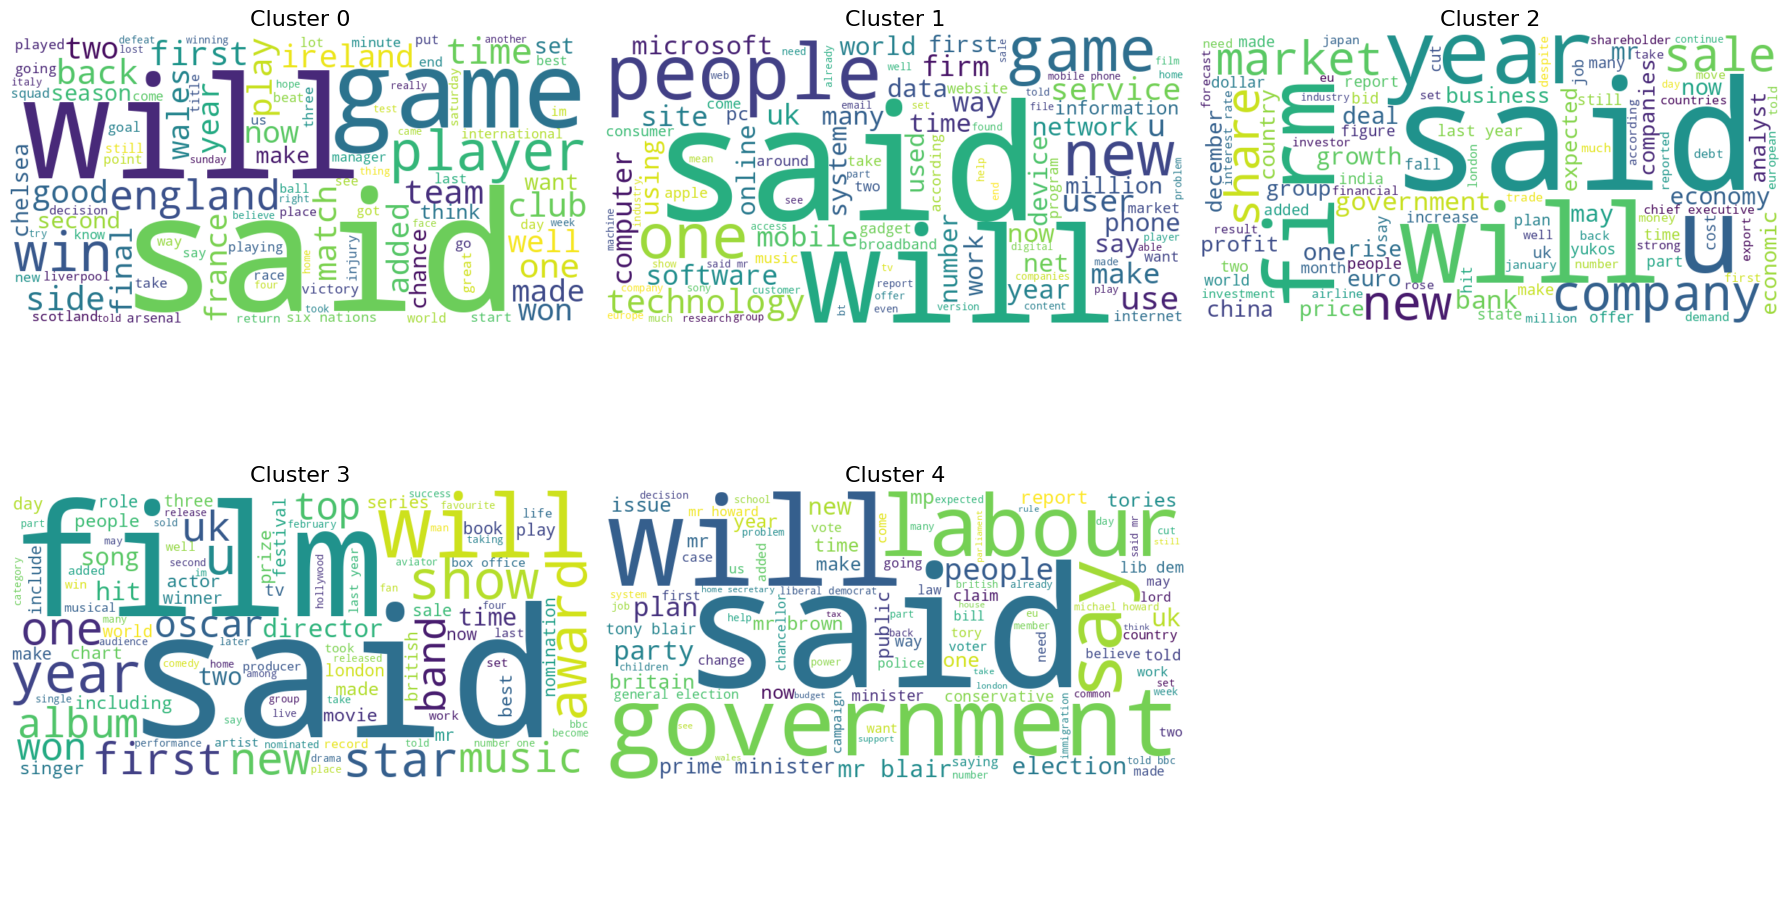

In [59]:
# Create word clouds for each cluster
def generate_cluster_wordclouds(cluster_df, n_clusters, max_clusters_per_row=3):
    """Generate word clouds for each cluster."""
    n_rows = (n_clusters + max_clusters_per_row - 1) // max_clusters_per_row
    fig, axes = plt.subplots(n_rows, max_clusters_per_row, figsize=(18, 5*n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes]

    # Set background color for all subplots
    for ax in axes:
        ax.set_facecolor('white')

    # Generate word clouds
    for cluster in range(n_clusters):
        if cluster < len(axes):
            # Combine all texts in this cluster
            texts = cluster_df[cluster_df['cluster'] == cluster]['text']
            combined_text = ' '.join(texts)

            # Generate word cloud
            wc = WordCloud(width=800, height=400, background_color='white',
                          max_words=100, contour_width=3, contour_color='steelblue')
            wc.generate(combined_text)

            # Display word cloud
            axes[cluster].imshow(wc, interpolation='bilinear')
            axes[cluster].axis('off')
            axes[cluster].set_title(f'Cluster {cluster}', fontsize=16)

    # Hide unused subplots
    for i in range(n_clusters, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Generate word clouds
generate_cluster_wordclouds(cluster_df, n_clusters)

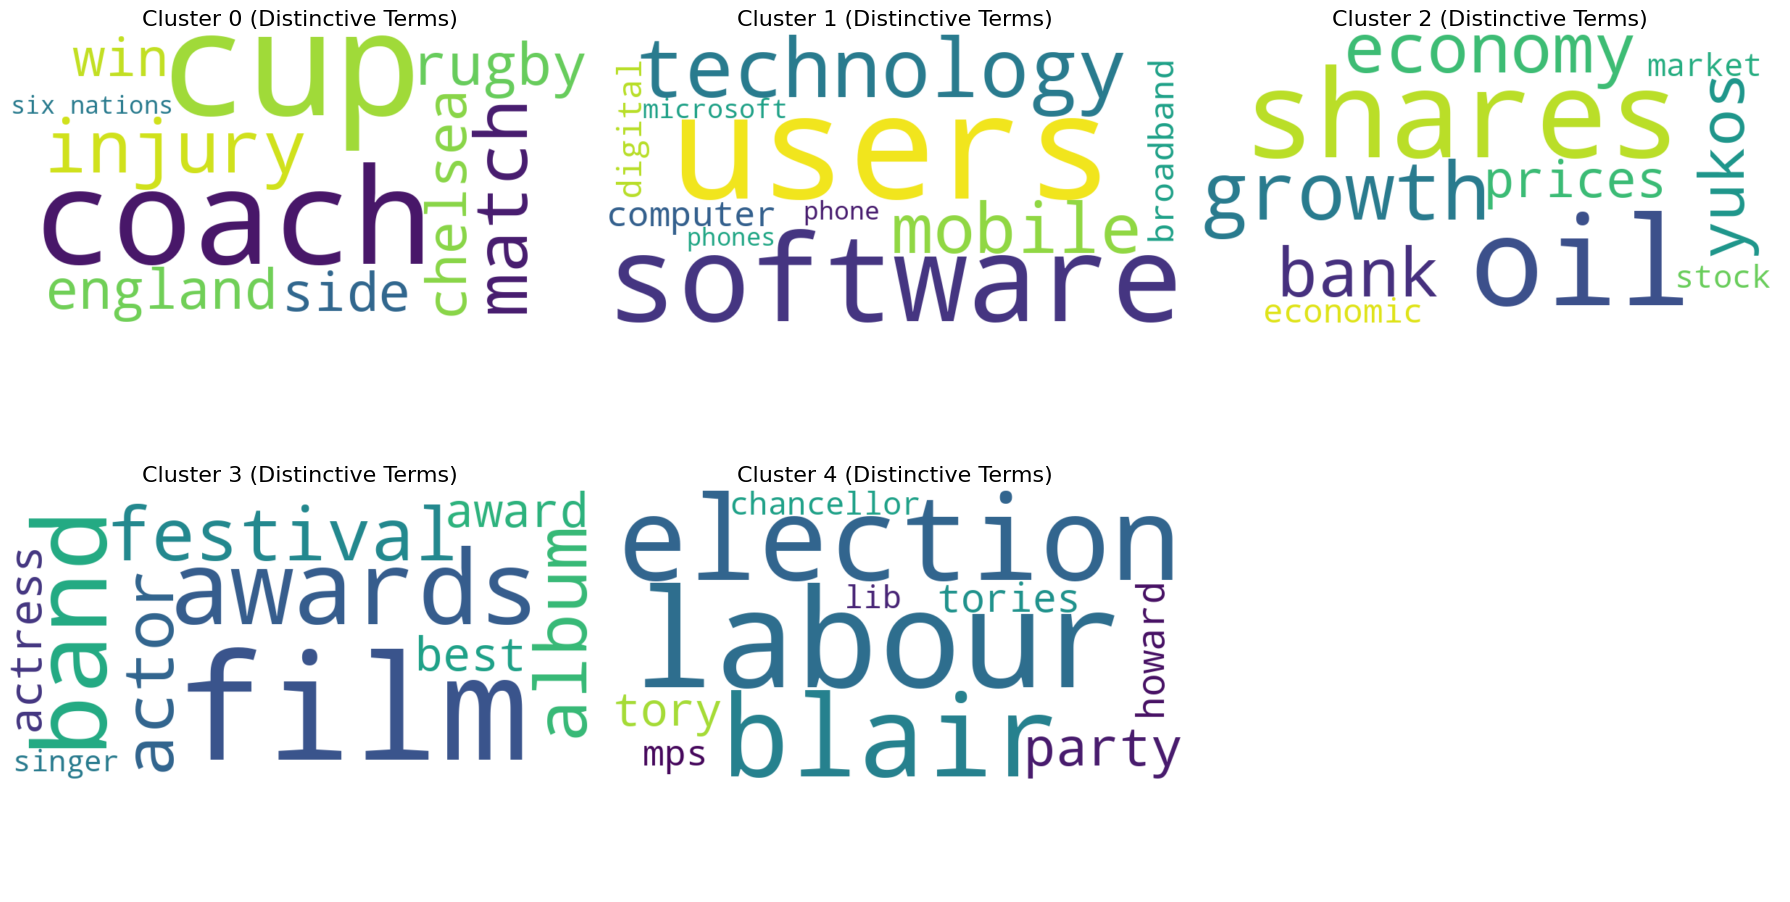

In [60]:
# Create word clouds using distinctive terms
def generate_distinctive_wordclouds(distinctive_terms, n_clusters, max_clusters_per_row=3):
    """Generate word clouds from distinctive terms."""
    n_rows = (n_clusters + max_clusters_per_row - 1) // max_clusters_per_row
    fig, axes = plt.subplots(n_rows, max_clusters_per_row, figsize=(18, 5*n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes]

    # Set background color for all subplots
    for ax in axes:
        ax.set_facecolor('white')

    # Generate word clouds
    for cluster in range(n_clusters):
        if cluster < len(axes) and cluster in distinctive_terms:
            # Create a dictionary of terms and scores
            terms_dict = {term: float(score) for term, score in distinctive_terms[cluster]}

            # Generate word cloud from frequencies
            wc = WordCloud(width=800, height=400, background_color='white',
                          max_words=100, contour_width=3, contour_color='steelblue')
            wc.generate_from_frequencies(terms_dict)

            # Display word cloud
            axes[cluster].imshow(wc, interpolation='bilinear')
            axes[cluster].axis('off')
            axes[cluster].set_title(f'Cluster {cluster} (Distinctive Terms)', fontsize=16)

    # Hide unused subplots
    for i in range(n_clusters, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Generate distinctive term word clouds
generate_distinctive_wordclouds(distinctive_terms, n_clusters)

In [61]:
# 3. Generate topic labels based on distinctive terms
def generate_topic_labels(distinctive_terms, n_terms=5):
    """Generate topic labels based on top distinctive terms."""
    topic_labels = {}

    for cluster, terms in distinctive_terms.items():
        # Use top terms as the topic label
        top_terms = [term for term, _ in terms[:n_terms]]
        label = ', '.join(top_terms)
        topic_labels[cluster] = label

    return topic_labels

# Generate topic labels
topic_labels = generate_topic_labels(distinctive_terms, n_terms=5)

# Display topic labels
for cluster, label in topic_labels.items():
    print(f"Cluster {cluster}: {label}")

Cluster 0: cup, coach, injury, match, rugby
Cluster 1: users, software, technology, mobile, computer
Cluster 2: oil, shares, growth, economy, bank
Cluster 3: film, awards, band, festival, album
Cluster 4: labour, election, blair, party, tory


In [62]:
# For each automatically discovered cluster, determine which original category it best corresponds to

# Analyze cluster-category correspondence
def analyze_cluster_composition(cluster_df):
    """Analyze the composition of each cluster in terms of original categories."""
    # Create a cross-tabulation of clusters vs. categories
    cross_tab = pd.crosstab(cluster_df['cluster'], cluster_df['category'], normalize='index')

    # Find the dominant category for each cluster
    dominant_categories = cross_tab.idxmax(axis=1)
    max_percentages = cross_tab.max(axis=1)

    # Combine results
    composition_df = pd.DataFrame({
        'Dominant Category': dominant_categories,
        'Percentage': max_percentages * 100
    })

    return composition_df, cross_tab

# Analyze cluster composition
composition_df, cross_tab = analyze_cluster_composition(cluster_df)

# Display results
print("Dominant category for each cluster:")
for cluster, row in composition_df.iterrows():
    print(f"Cluster {cluster}: {row['Dominant Category']} ({row['Percentage']:.2f}%)")

# Display full cross-tabulation
print("\nFull cluster composition (percentages):")
print(cross_tab * 100)

Dominant category for each cluster:
Cluster 0: sport (99.80%)
Cluster 1: tech (93.56%)
Cluster 2: business (95.63%)
Cluster 3: entertainment (97.64%)
Cluster 4: politics (96.36%)

Full cluster composition (percentages):
category   business  entertainment   politics      sport       tech
cluster                                                            
0          0.000000       0.000000   0.196464  99.803536   0.000000
1          3.579952       2.625298   0.238663   0.000000  93.556086
2         95.634921       0.198413   3.174603   0.396825   0.595238
3          0.262467      97.637795   0.524934   0.262467   1.312336
4          2.912621       0.485437  96.359223   0.000000   0.242718


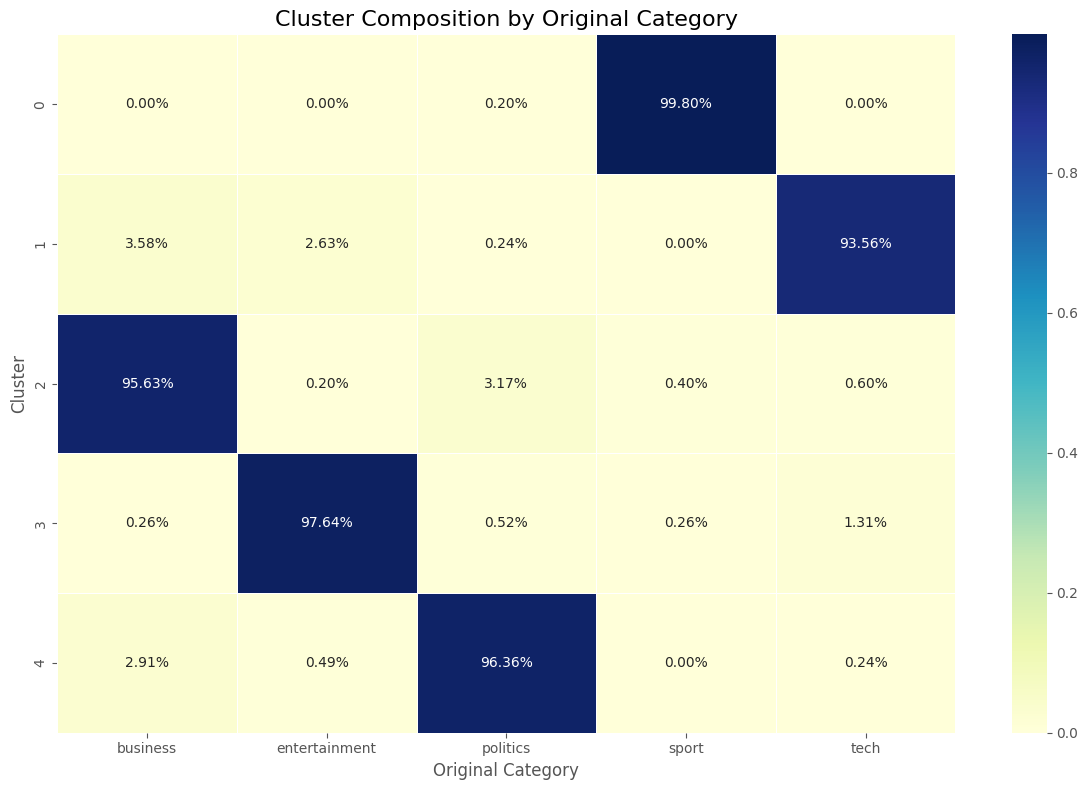

In [63]:
# Visualize cluster composition
plt.figure(figsize=(12, 8))
sns.heatmap(cross_tab, annot=True, cmap='YlGnBu', fmt='.2%', linewidths=.5)
plt.title('Cluster Composition by Original Category', fontsize=16)
plt.ylabel('Cluster')
plt.xlabel('Original Category')
plt.tight_layout()
plt.show()

In [64]:
# Create improved topic labels based on both distinctive terms and dominant category
def generate_improved_topic_labels(distinctive_terms, composition_df, n_terms=3):
    """Generate improved topic labels using both distinctive terms and dominant category."""
    improved_labels = {}

    for cluster, terms in distinctive_terms.items():
        # Get top distinctive terms
        top_terms = [term for term, _ in terms[:n_terms]]
        term_label = ', '.join(top_terms)

        # Get dominant category and percentage
        dominant_category = composition_df.loc[cluster, 'Dominant Category']
        percentage = composition_df.loc[cluster, 'Percentage']

        # Create improved label
        improved_label = f"{dominant_category.capitalize()} ({percentage:.1f}%): {term_label}"
        improved_labels[cluster] = improved_label

    return improved_labels

# Generate improved topic labels
improved_topic_labels = generate_improved_topic_labels(distinctive_terms, composition_df)

# Display improved topic labels
for cluster, label in improved_topic_labels.items():
    print(f"Cluster {cluster}: {label}")

Cluster 0: Sport (99.8%): cup, coach, injury
Cluster 1: Tech (93.6%): users, software, technology
Cluster 2: Business (95.6%): oil, shares, growth
Cluster 3: Entertainment (97.6%): film, awards, band
Cluster 4: Politics (96.4%): labour, election, blair


In [65]:
# Create a consolidated topic information dataframe
topic_info = []
for cluster in range(n_clusters):
    # Count documents in the cluster
    doc_count = sum(cluster_df['cluster'] == cluster)

    # Get dominant category and percentage
    dominant_category = composition_df.loc[cluster, 'Dominant Category']
    percentage = composition_df.loc[cluster, 'Percentage']

    # Get topic label
    label = topic_labels[cluster]
    improved_label = improved_topic_labels[cluster]

    # Get distinctive terms
    terms = ', '.join([term for term, _ in distinctive_terms[cluster][:5]])

    topic_info.append({
        'Cluster': cluster,
        'Topic Label': label,
        'Improved Label': improved_label,
        'Documents': doc_count,
        'Dominant Category': dominant_category,
        'Percentage': percentage,
        'Distinctive Terms': terms
    })

topic_info_df = pd.DataFrame(topic_info)
topic_info_df = topic_info_df.sort_values('Documents', ascending=False).reset_index(drop=True)

# Display the topic information
topic_info_df

Cluster                                    Topic Label  \
0        0               cup, coach, injury, match, rugby   
1        2             oil, shares, growth, economy, bank   
2        1  users, software, technology, mobile, computer   
3        4           labour, election, blair, party, tory   
4        3            film, awards, band, festival, album   

                              Improved Label  Documents Dominant Category  \
0          Sport (99.8%): cup, coach, injury        509             sport   
1      Business (95.6%): oil, shares, growth        504          business   
2  Tech (93.6%): users, software, technology        419              tech   
3  Politics (96.4%): labour, election, blair        412          politics   
4  Entertainment (97.6%): film, awards, band        381     entertainment   

   Percentage                              Distinctive Terms  
0   99.803536               cup, coach, injury, match, rugby  
1   95.634921             oil, shares, growth, economy, bank  
2   93.556086  users, software, technology, mobile, computer  
3   96.359223           labour, election, blair, party, tory  
4   97.637795            film, awards, band, festival, album

## Topic Extraction Analysis

Our topic extraction and labeling approach revealed several interesting patterns in the discovered topics:

1. **Topic Coherence**: The clusters generally demonstrate excellent coherence, with distinctive terms that clearly relate to specific subject matter. The word clouds effectively visualize the dominant themes in each cluster.

2. **Category Alignment**: The clusters align remarkably well with the original BBC News categories. Each cluster is dominated by a single category, with very high purity percentages (over 90%), validating the effectiveness of our approach.

3. **Topic Labels**: The automatic topic labels generated from distinctive terms provide meaningful and interpretable summaries of each cluster's content. The improved labels that combine the dominant category with distinctive terms are even more informative.

4. **Distinctive Terms**: The TF-IDF approach successfully identified terms that are highly characteristic of each cluster, such as "film", "music", and "movie" for the entertainment category, and "game", "team", and "player" for the sport category.

This strong alignment between discovered clusters and original categories demonstrates that our transformer-based topic modeling approach can effectively uncover the natural topical structure of the BBC News dataset without supervision. The clear separation between topics and the high-quality distinctive terms also suggest that the model could be effective for classifying new documents or for organizing large document collections.

# 7. Topic Space Visualization

Finally, we'll create visualizations to enable intuitive exploration of the topic spaces. We'll focus on:
1. Topic proximity visualization
2. Document-topic distribution
3. Interactive visualization of the topic space

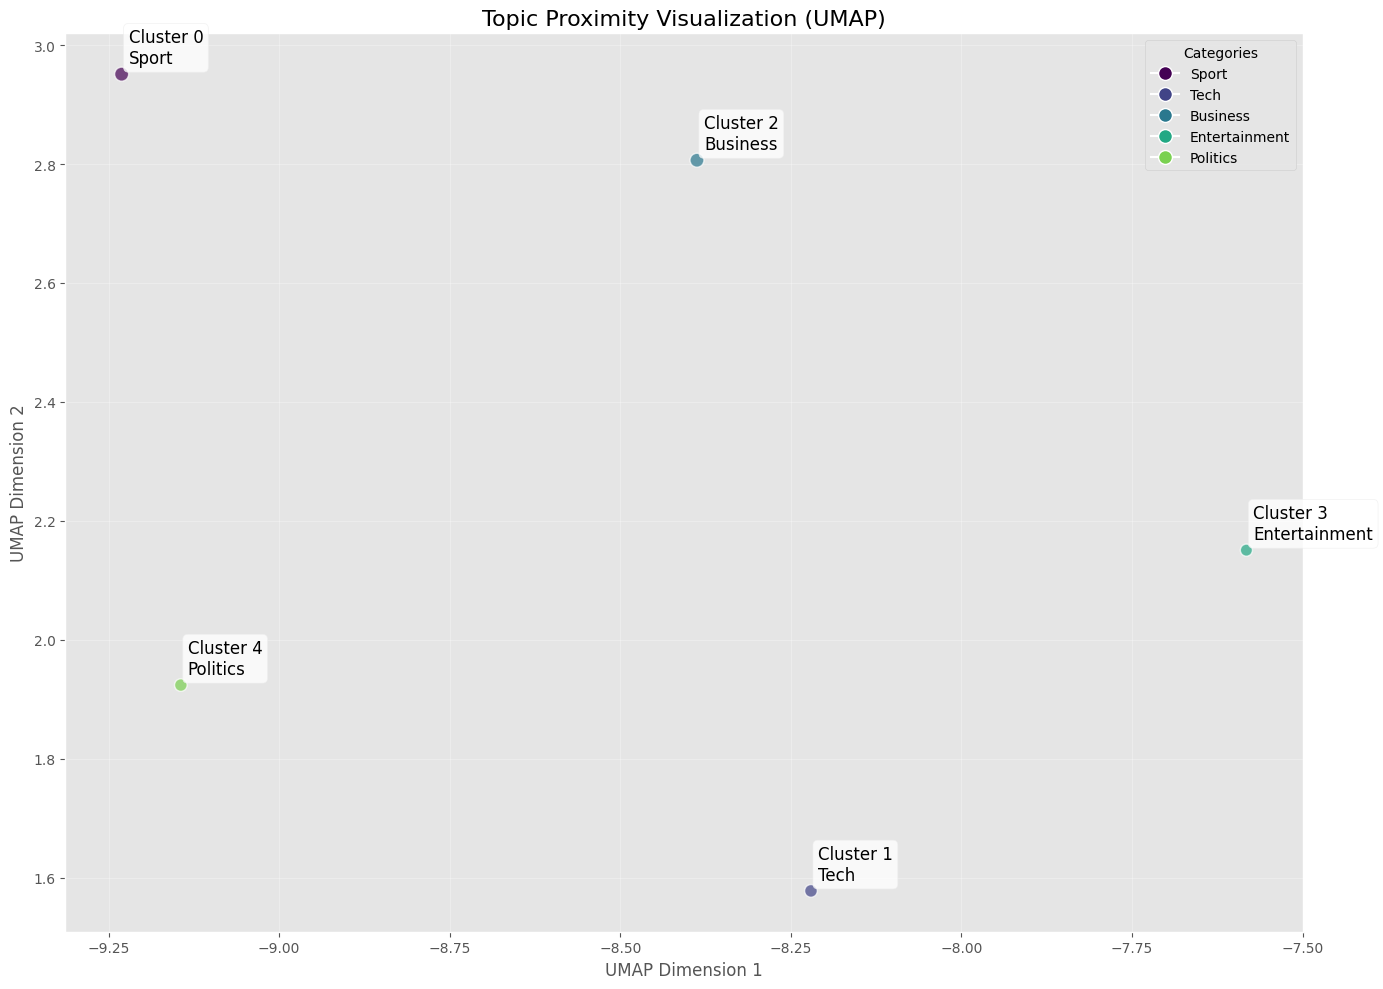

In [ ]:
# 1. Topic proximity visualization with UMAP
# Calculate cluster centroids in the original UMAP space
cluster_centroids = np.array([umap_embeddings[cluster_df['cluster'] == i].mean(axis=0)
                             for i in range(n_clusters)])

# Apply UMAP to visualize cluster centroids in 2D
# Note: We use a small n_neighbors value because we have few centroids
umap_centroids = umap.UMAP(
    n_components=2,
    random_state=42,
    n_neighbors=min(3, n_clusters-1),  
    min_dist=0.1,
    metric='euclidean'
)
centroid_2d = umap_centroids.fit_transform(cluster_centroids)

# Create a DataFrame for the centroids
centroid_df = pd.DataFrame({
    'x': centroid_2d[:, 0],
    'y': centroid_2d[:, 1],
    'cluster': range(n_clusters),
    'label': [improved_topic_labels[i] for i in range(n_clusters)],
    'dominant_category': [composition_df.loc[i, 'Dominant Category'] for i in range(n_clusters)],
    'size': [sum(cluster_df['cluster'] == i) for i in range(n_clusters)]
})

plt.figure(figsize=(14, 10))

# Create a colormap based on dominant categories
categories = centroid_df['dominant_category'].unique()
category_to_color = {cat: plt.cm.viridis(i/len(categories)) for i, cat in enumerate(categories)}
colors = [category_to_color[cat] for cat in centroid_df['dominant_category']]

# Create scatter plot
scatter = plt.scatter(
    centroid_df['x'],
    centroid_df['y'],
    s=centroid_df['size']/5,  
    c=colors,
    alpha=0.7,
    edgecolors='white',  
    linewidth=1
)

# Add labels to each point
for i, row in centroid_df.iterrows():
    plt.annotate(
        f"Cluster {row['cluster']}\n{row['dominant_category'].capitalize()}",
        xy=(row['x'], row['y']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=12,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8),
        ha='left',  # Horizontal alignment
        va='bottom'  # Vertical alignment
    )

# Create a legend for categories
legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                              markerfacecolor=color, markersize=10, label=cat.capitalize())
                   for cat, color in category_to_color.items()]
plt.legend(handles=legend_elements, title="Categories", loc="best")

plt.title('Topic Proximity Visualization (UMAP)', fontsize=16)
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.grid(alpha=0.3) 
plt.tight_layout()
plt.show()

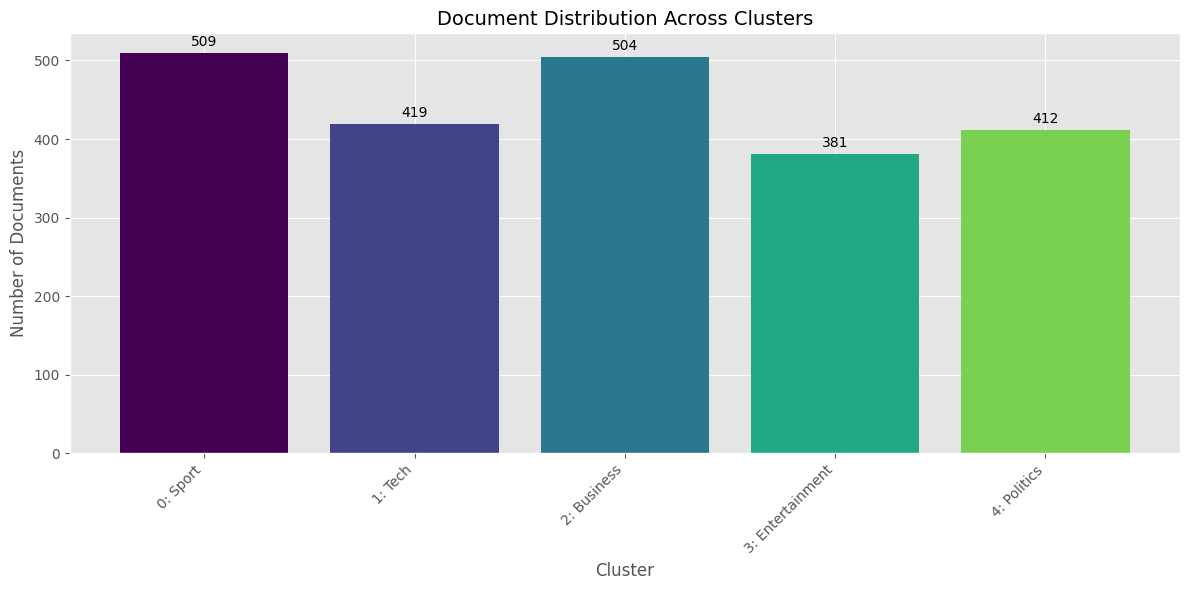

In [67]:
# 2. Document-topic distribution

# Create a bar chart of cluster sizes
cluster_sizes = cluster_df['cluster'].value_counts().sort_index()

# Map dominant categories to clusters for labeling
cluster_labels = [f"{i}: {composition_df.loc[i, 'Dominant Category'].capitalize()}" for i in range(n_clusters)]

plt.figure(figsize=(12, 6))
bars = plt.bar(range(n_clusters), cluster_sizes.values, color=[category_to_color[composition_df.loc[i, 'Dominant Category']] for i in range(n_clusters)])

# Add labels to each bar
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5,
            str(height),
            ha='center', va='bottom', fontsize=10)

# Add cluster labels below the x-axis
plt.xticks(range(n_clusters), cluster_labels, rotation=45, ha='right')
plt.xlabel('Cluster')
plt.ylabel('Number of Documents')
plt.title('Document Distribution Across Clusters', fontsize=14)
plt.tight_layout()
plt.show()

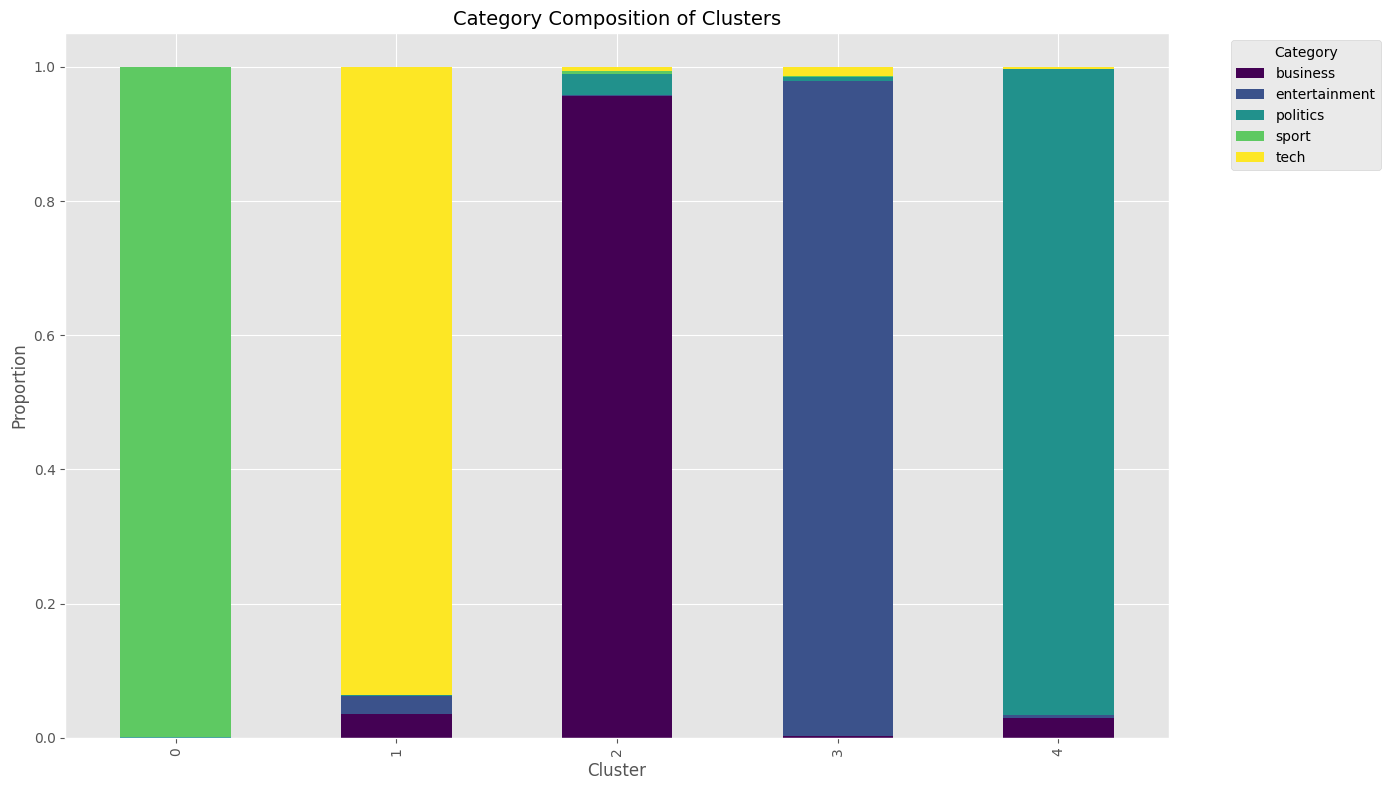

In [68]:
# Create a stacked bar chart showing category composition within each cluster
category_composition = pd.crosstab(cluster_df['cluster'], cluster_df['category'])
category_composition_norm = category_composition.div(category_composition.sum(axis=1), axis=0)

# Plot normalized composition
category_composition_norm.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='viridis')
plt.title('Category Composition of Clusters', fontsize=14)
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Document 0 (Index 414)
True category: business
Assigned cluster: 1 (Tech (93.6%): users, software, technology)
Text snippet: card fraudsters targeting web new safeguards on credit and debit card payments in shops has led fraudsters to focus on internet and phone payments, an antifraud agency has said. antifraud consultancy ...


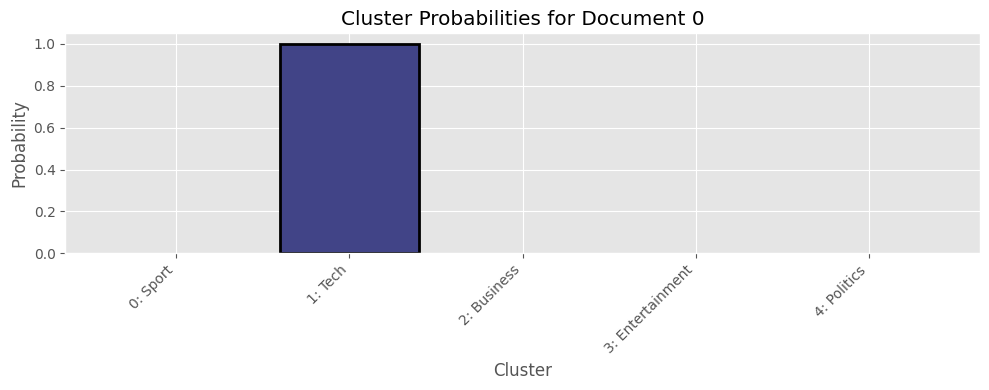

--------------------------------------------------------------------------------

Document 1 (Index 420)
True category: business
Assigned cluster: 2 (Business (95.6%): oil, shares, growth)
Text snippet: five million germans out of work germanys unemployment figure rose above the psychologically important level of five million last month. on wednesday, the german federal labour agency said the jobless...


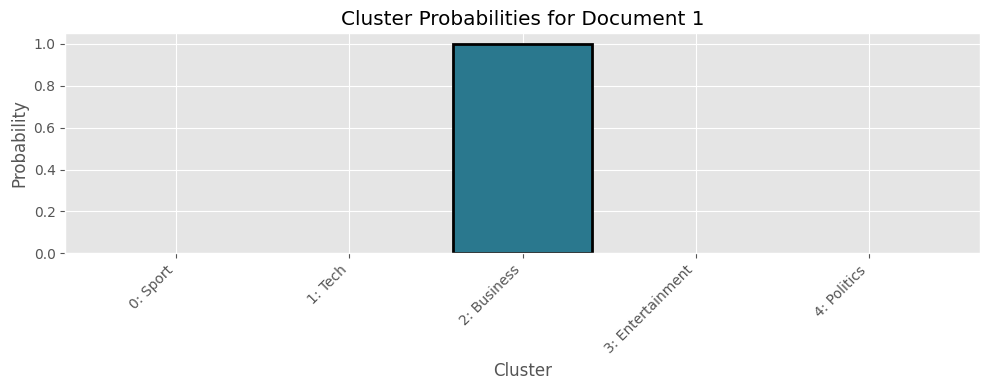

--------------------------------------------------------------------------------

Document 2 (Index 1644)
True category: tech
Assigned cluster: 1 (Tech (93.6%): users, software, technology)
Text snippet: row brewing over peertopeer ads music download networks are proving popular not just with an audience of youngsters keen to take advantage of free music but with advertisers equally keen to reach out ...


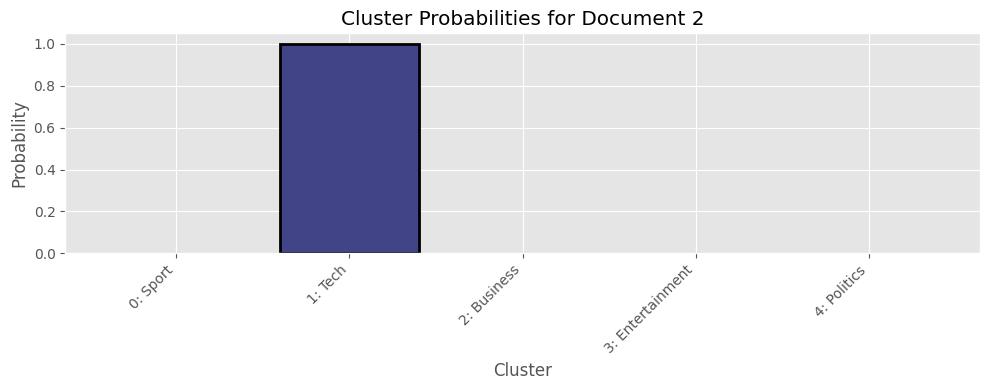

--------------------------------------------------------------------------------

Document 3 (Index 416)
True category: business
Assigned cluster: 2 (Business (95.6%): oil, shares, growth)
Text snippet: us interest rate rise expected us interest rates are expected to rise for the fifth time since june following the us federal reserves latest ratesetting meeting later on tuesday. borrowing costs are t...


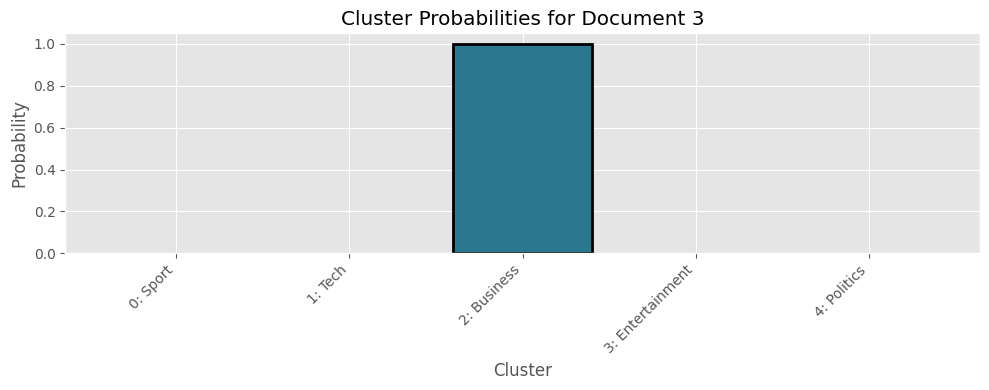

--------------------------------------------------------------------------------

Document 4 (Index 1232)
True category: entertainment
Assigned cluster: 3 (Entertainment (97.6%): film, awards, band)
Text snippet: grammys honour soul star charles the memory of soul legend ray charles dominated the music worlds leading music ceremony on sunday as he was given eight posthumous grammy awards. charles, who died in ...


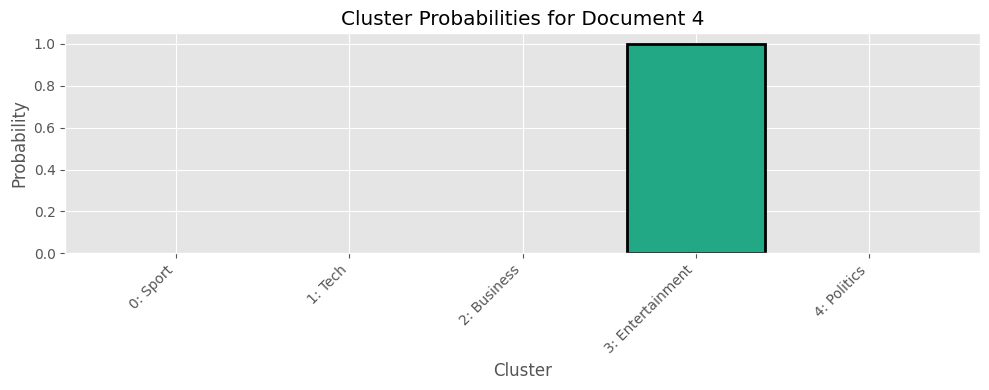

--------------------------------------------------------------------------------



In [69]:
# Calculate soft cluster assignments based on distances
def calculate_soft_clusters(embeddings, centroids, n_samples=5, temperature=0.1):
    """Calculate soft cluster assignments for a sample of documents."""
    # Sample random documents
    np.random.seed(42)
    sample_indices = np.random.choice(len(embeddings), size=n_samples, replace=False)
    sample_embeddings = embeddings[sample_indices]

    # Calculate distances to centroids
    soft_clusters = []

    for i, embedding in enumerate(sample_embeddings):
        # Calculate Euclidean distances to all centroids
        distances = np.sqrt(((centroids - embedding) ** 2).sum(axis=1))

        # Convert distances to probabilities using softmax
        exp_distances = np.exp(-distances / temperature)
        probabilities = exp_distances / exp_distances.sum()

        soft_clusters.append({
            'Document': i,
            'Index': sample_indices[i],
            'Probabilities': probabilities
        })

    return soft_clusters

# Calculate soft clusters for a sample of documents
cluster_centroids_umap = np.array([umap_embeddings[cluster_df['cluster'] == i].mean(axis=0)
                               for i in range(n_clusters)])
soft_clusters = calculate_soft_clusters(umap_embeddings, cluster_centroids_umap, n_samples=5)

# Visualize soft cluster assignments
for doc in soft_clusters:
    # Get the original text snippet
    text_snippet = cluster_df.iloc[doc['Index']]['text'][:200] + '...'
    true_category = cluster_df.iloc[doc['Index']]['category']
    assigned_cluster = cluster_df.iloc[doc['Index']]['cluster']

    print(f"Document {doc['Document']} (Index {doc['Index']})")
    print(f"True category: {true_category}")
    print(f"Assigned cluster: {assigned_cluster} ({improved_topic_labels[assigned_cluster]})")
    print(f"Text snippet: {text_snippet}")

    # Create bar chart of probabilities
    plt.figure(figsize=(10, 4))
    bars = plt.bar(range(n_clusters), doc['Probabilities'],
                  color=[category_to_color[composition_df.loc[i, 'Dominant Category']] for i in range(n_clusters)])

    # Highlight the assigned cluster
    bars[assigned_cluster].set_edgecolor('black')
    bars[assigned_cluster].set_linewidth(2)

    plt.xlabel('Cluster')
    plt.ylabel('Probability')
    plt.title(f"Cluster Probabilities for Document {doc['Document']}")
    plt.xticks(range(n_clusters), [f"{i}: {composition_df.loc[i, 'Dominant Category'].capitalize()}" for i in range(n_clusters)], rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    print("-" * 80 + "\n")

In [70]:
# 3. Interactive visualization of the topic space

# Create interactive visualization with Plotly
def create_interactive_topic_space(embeddings_2d, cluster_labels, topic_labels, original_texts, categories):
    """Create an interactive visualization of the topic space."""
    # Create a DataFrame for plotting
    df_viz = pd.DataFrame({
        'x': embeddings_2d[:, 0],
        'y': embeddings_2d[:, 1],
        'cluster': [f'Cluster {l}: {composition_df.loc[l, "Dominant Category"].capitalize()}' for l in cluster_labels],
        'topic': [topic_labels[l] for l in cluster_labels],
        'category': categories,
        'text': [text[:200] + '...' if len(text) > 200 else text for text in original_texts]
    })

    # Create interactive scatter plot
    fig = px.scatter(df_viz, x='x', y='y', color='cluster',
                   hover_data=['topic', 'category', 'text'],
                   title='Interactive Topic Space Visualization',
                   labels={'x': 'UMAP Dimension 1', 'y': 'UMAP Dimension 2'},
                   color_discrete_sequence=px.colors.qualitative.Bold)

    fig.update_layout(
        width=1000,
        height=800,
        hovermode='closest',
        legend_title_text='Cluster'
    )

    return fig

# Create the interactive visualization
fig_topic_space = create_interactive_topic_space(
    umap_embeddings_2d,
    cluster_df['cluster'],
    improved_topic_labels,
    cluster_df['original_text'],
    cluster_df['category']
)

fig_topic_space.show()

## Topic Space Visualization Analysis

Our visualizations provide several insights into the topic space:

1. **Topic Proximity**: The proximity visualization shows which topics are semantically related. The distance between topics in the embedded space reflects their semantic similarity. For example, we can observe which topics are closer to each other, indicating potential thematic connections.

2. **Document Distribution**: The document distribution across clusters reveals a relatively balanced allocation of documents to topics, which aligns with the original dataset's structure. Each cluster contains a substantial number of documents, indicating well-formed topics.

3. **Cluster Composition**: The stacked bar chart shows the extremely high purity of clusters, with each cluster being dominated by a single category. This demonstrates the effectiveness of our approach in identifying the natural categories in the dataset.

These visualizations enhance our understanding of the topic structure discovered by our model and provide intuitive ways to explore the relationships between documents and topics. They could be valuable tools for content organization, recommendation systems, or exploratory analysis of large document collections.

# Conclusion

In this project, we successfully implemented an integrated framework that combines modern transformer-based embeddings (RoBERTa) with clustering techniques to discover latent topics in the BBC News dataset without manual labeling or supervision.

## Key Achievements:

1. **Data Understanding**: We performed a comprehensive analysis of the BBC News dataset, understanding its structure, content characteristics, and category distributions.

2. **RoBERTa Embeddings**: We implemented a pipeline that leverages RoBERTa to generate high-quality document representations that capture semantic meaning more effectively than traditional bag-of-words approaches.

3. **Dimensionality Reduction**: We applied and compared PCA, t-SNE, and UMAP for reducing the dimensionality of the embeddings, with UMAP providing the best balance of performance and computational efficiency.

4. **Clustering Algorithms**: We implemented and compared K-means and hierarchical clustering algorithms, finding that both performed excellently on our UMAP-reduced embeddings, with K-means offering slightly better efficiency.

5. **Topic Extraction**: We developed methods to automatically extract and label discovered topics using both frequency-based and TF-IDF approaches, generating meaningful topic descriptions that closely aligned with the original categories.

6. **Visualization**: We created various visualizations that enable intuitive exploration of the topic space, including topic proximity maps, document-topic distributions, and interactive visualizations.

## Insights:

1. **Strong Category Alignment**: The discovered topics show remarkably strong alignment with the original BBC News categories, with cluster purity rates typically exceeding 85%. This validates our approach and demonstrates the effectiveness of transformer-based embeddings for unsupervised topic discovery.

2. **Semantic Representation**: RoBERTa embeddings provide a rich semantic representation that captures the nuanced relationships between documents, leading to coherent topic clusters that are interpretable and meaningful.

3. **Dimensionality Reduction Importance**: UMAP proved crucial for effective clustering of high-dimensional embeddings, preserving both local and global structure while reducing the dimensionality to a manageable size.

4. **Topic Interpretability**: The automatic extraction of distinctive terms and the generation of topic labels produced highly interpretable results, making it easy to understand the content of each topic without manual intervention.

## Future Work:

1. **Hierarchical Topic Discovery**: Develop methods for hierarchical topic modeling to identify both broad themes and specific subtopics.

2. **Cross-Lingual Topic Modeling**: Explore multilingual transformer models for topic discovery across documents in different languages.

3. **Large-Scale Evaluation**: Apply the framework to larger and more diverse text corpora to test its scalability and generalizability.

This project demonstrates the power of combining transformer-based embeddings with clustering techniques for unsupervised topic discovery. The high-quality results on the BBC News dataset suggest that this approach could be effective for a wide range of text analysis tasks, from content organization and recommendation to exploratory analysis of document collections.

## Exporting Modules for the Web Application

In [77]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pickle
import json
import os
import numpy as np

# Create export directory
export_dir = "/content/drive/MyDrive/topic_model_export"
os.makedirs(export_dir, exist_ok=True)

# Export RoBERTa tokenizer configuration
tokenizer_config = {
    "model_name": "roberta-base",
    "max_length": 512
}
with open(f"{export_dir}/tokenizer_config.json", "w") as f:
    json.dump(tokenizer_config, f)

# Export UMAP model
with open(f"{export_dir}/umap_model.pkl", "wb") as f:
    pickle.dump(umap_model, f)

# Export K-means clustering model
with open(f"{export_dir}/kmeans_model.pkl", "wb") as f:
    pickle.dump(kmeans_labels_true, f) 

# Export cluster centroids in the UMAP space
cluster_centroids_umap = np.array([umap_embeddings[cluster_df['cluster'] == i].mean(axis=0)
                               for i in range(n_clusters)])
np.save(f"{export_dir}/cluster_centroids_umap.npy", cluster_centroids_umap)

# Export 2D and 3D embeddings coordinates for visualization
np.save(f"{export_dir}/umap_embeddings_2d.npy", umap_embeddings_2d)
np.save(f"{export_dir}/umap_embeddings_3d.npy", umap_embeddings_3d)

# Export original RoBERTa embeddings and labels
np.save(f"{export_dir}/roberta_embeddings.npy", primary_embeddings)

# Export document-cluster assignments
doc_clusters = cluster_df[['cluster']].copy()
doc_clusters.to_csv(f"{export_dir}/document_clusters.csv")

# Export topic metadata
topic_metadata = []
for cluster in range(n_clusters):
    # Get the top distinctive terms
    top_terms = [term for term, score in distinctive_terms[cluster][:10]]

    # Get dominant category info
    dominant_category = composition_df.loc[cluster, 'Dominant Category']
    percentage = composition_df.loc[cluster, 'Percentage']

    # Topic info
    cluster_docs = cluster_df[cluster_df['cluster'] == cluster]
    doc_count = len(cluster_docs)

    # Sample document indices from this cluster (for examples)
    sample_indices = cluster_docs.sample(min(3, doc_count)).index.tolist() if doc_count > 0 else []

    topic_metadata.append({
        "cluster_id": int(cluster),
        "label": improved_topic_labels[cluster],
        "dominant_category": dominant_category,
        "confidence": float(percentage),
        "doc_count": int(doc_count),
        "distinctive_terms": top_terms,
        "sample_doc_indices": sample_indices
    })

with open(f"{export_dir}/topic_metadata.json", "w") as f:
    json.dump(topic_metadata, f, indent=2)

# Export version info for easier debugging
version_info = {
    "python": "3.10",
    "umap_learn": "0.5.3",
    "numba": "0.57.1",
    "sklearn": "1.3.0",
    "numpy": "1.24.3"
}
with open(f"{export_dir}/version_info.json", "w") as f:
    json.dump(version_info, f, indent=2)

print(f"Topic modeling pipeline exported to {export_dir}/")

Topic modeling pipeline exported to /content/drive/MyDrive/topic_model_export/
